In [1]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from astropy.io import ascii

from astropy.constants import c 
__C_LIGHT_KMS__ = c.to('km/s').value
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.74, Om0=0.3089)
import os
plt.style.use(['seaborn-v0_8-deep', os.environ['HOME'] + '/.matplotlib_style/paper.mplstyle'])
plt.rcParams['text.latex.preamble'] =  r"\usepackage{amsmath} \usepackage{xcolor} "
import scipy.stats as scs
from pathlib import Path
import flip
import sys
sys.path.append('/global/homes/b/bastienc/')
sys.path.append('../scripts/')

import my_utils as mut
import flip
import paper_fun as pf

PIPPIN_DIR = Path(os.environ['PIPPIN_OUTPUT'])
KEYS = ['C11', 'G10', 'P21', 'RNDSMEAR']
TRIPP_KEYS = ['alpha', 'beta', 'M_0', 'sigma_M', 'gamma']

[ 000000.00 ]: 05-15 11:31  root            INFO     No pypower module detected, gridding with this method is unavailable
[ 000000.00 ]: 05-15 11:31  root            INFO     Jax is not available, loading numpy and scipy instead


# Main paper

## $f\sigma_8$ results

In [2]:
FS8_RESULT_TABLE_HEADER =r"""\begin{table*}
\renewcommand{\arraystretch}{2}
\centering
    \begin{tabular}{c||c|c|c||c|c|c||c|c|c||c}
\multirow{2}{*}{Models} & \multicolumn{3}{c||}{True fit}                                                                                        & \multicolumn{3}{c||}{Standard fit}                                                                                    & \multicolumn{3}{c||}{BBC fit}                                                                                         & \multicolumn{1}{c}{}  \\ 
\cline{2-10}
                        & $\langle\fsig\rangle / \left(\fsig\right)_\mathrm{fid}$ & $\sqrt{\langle\sigma_{\fsig}^2\rangle}$ & STD($\fsig$) & $\langle\fsig\rangle / \left(\fsig\right)_\mathrm{fid}$ & $\sqrt{\langle\sigma_{\fsig}^2\rangle}$ & STD($\fsig$) & $\langle\fsig\rangle / \left(\fsig\right)_\mathrm{fid}$ & $\sqrt{\langle\sigma_{\fsig}^2\rangle}$ & STD($\fsig$) & \multicolumn{1}{c}{}  \\ 
\hhline{=#===#===#===#}
"""


FS8_RESULT_TABLE_FOOTER=r"""
\end{tabular}
\end{table*}
"""
fs8_res="{} & {:.3f} $\pm$ {:.3f} & {:.1f}\% & {:.1f}\% & {:.3f} $\pm$ {:.3f} & {:.1f}\% & {:.1f}\% & {:.3f} $\pm$ {:.3f} & {:.1f}\% & {:.1f}\%".format

In [3]:
FS8SYS_RESULT_TABLE_HEADER = r"""\begin{table*}
    \centering
    \renewcommand{\arraystretch}{2}
    
    \begin{tabular}{c||c|c}
        & $\langle\fsig\rangle / \left(\fsig\right)_\mathrm{fid}$ & $\sqrt{\langle\sigma_{\fsig}^2\rangle} $ \\ 
        \hhline{=::==}"""

fs8sys_res="{} & {:.4f} $\pm$ {:.4f} & {:.2f}\%".format

FS8SYS_RESULT_TABLE_FOOTER = r"""    \end{tabular}
\end{table*}
"""


In [4]:
results_models_path = Path('../results/')
results_P21_intsct_path = Path('../results_p21/')
results_P21_sigu_path = Path('../results_p21_sigu/')


In [5]:
res_models = []
for f in sorted(results_models_path.glob('*_nojax.csv')):
    res_models.append(pd.read_csv(f, index_col=0))
resdf = pd.concat(res_models, keys=np.arange(8))
grp_models = resdf.groupby('model')

res_P21_intsct = []
for f in sorted(results_P21_intsct_path.glob('*_nojax.csv')):
    res_P21_intsct.append(pd.read_csv(f, index_col=0))
res_P21_intsct_df = pd.concat(res_P21_intsct, keys=np.arange(8))
grp_P21_intsct_mocks = res_P21_intsct_df.groupby(level=0)


# SIGU
def dfs8(df):
    return pd.DataFrame({'sigu': df.sigu.values, 
                         'fs8_TRUE': df.fs8_TRUE.values,
                         'dfs8_BBC': df.fs8_BBC.values / df.fs8_BBC.values[11]  - 1,
                        'dfs8_TRUE': df.fs8_TRUE.values  / df.fs8_TRUE.values[11] - 1,
                        'dfs8_STDFIT': df.fs8_STDFIT.values / df.fs8_STDFIT.values[11] - 1})
res_P21_sigu = []
for f in sorted(results_P21_sigu_path.glob('*_nojax.csv')):
    res_P21_sigu.append(pd.read_csv(f, index_col=0))
res_P21_sigu_df = pd.concat(res_P21_sigu, keys=np.arange(8))
gsigu = res_P21_sigu_df.groupby(level=0).apply(dfs8)


TRUE RES: res = [6.20171333e-07]
BBC RES: [5.24200685e-07]
STDFIT RES: [7.87313226e-07]
TRUE p = 0.61e-3 * x^2 + 26.71e-3 * x^1 + 0.21e-3 * x^0 + 
BBC p = 0.11e-3 * x^2 + 12.21e-3 * x^1 + -0.11e-3 * x^0 + 
STDFIT p = 0.11e-3 * x^2 + 9.71e-3 * x^1 + -0.31e-3 * x^0 + 
-5 sigma : 19.145561400477522
+5 sigma : 24.129771549043934
0 sigma : 21.46433417060371


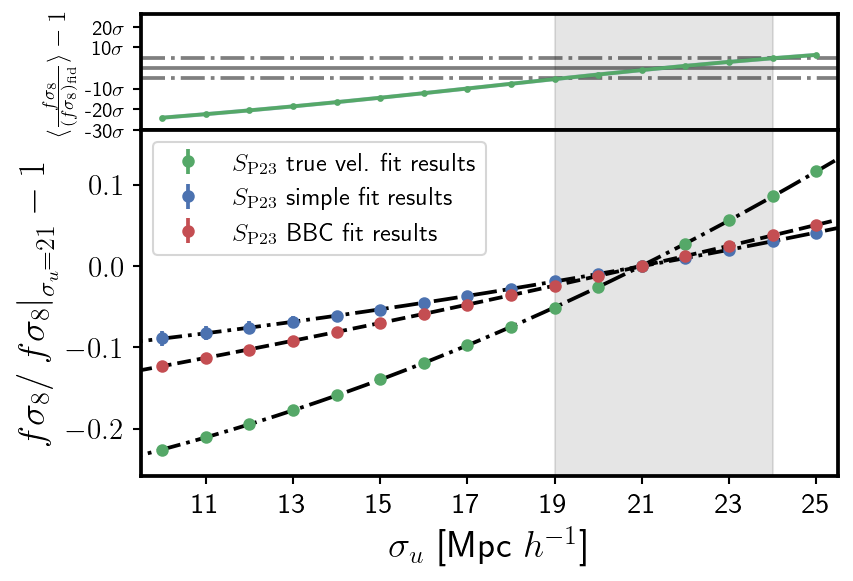

In [6]:
from scipy.stats import linregress
gsu = gsigu.groupby('sigu')

group_values = np.array(list(gsu.groups.keys())) - 21
fig, ax = plt.subplots(2, 1, dpi=150, figsize=(6, 4),
                       sharex=True,height_ratios=[0.25, 0.75])

coefficients_TRUE = np.polyfit(group_values,  gsu.dfs8_TRUE.mean(), 2, full=True)
p_TRUE = np.poly1d(coefficients_TRUE[0])
coefficients_BBC = np.polyfit(group_values,  gsu.dfs8_BBC.mean(), 2, full=True)
p_BBC = np.poly1d(coefficients_BBC[0])
coefficients_STDFIT = np.polyfit(group_values,  gsu.dfs8_STDFIT.mean(), 2, full=True)
p_STDFIT = np.poly1d(coefficients_STDFIT[0])


print(f'TRUE RES: res = {coefficients_TRUE[1]}')
print(f'BBC RES: {coefficients_BBC[1]}')
print(f'STDFIT RES: {coefficients_STDFIT[1]}')

print(f'TRUE p = ' + ''.join([f'{k*1e3:.1f}1e-3 * x^{2-i} + ' for i, k in enumerate(coefficients_TRUE[0])]))
print(f'BBC p = ' + ''.join([f'{k*1e3:.1f}1e-3 * x^{2-i} + ' for i, k in enumerate(coefficients_BBC[0])]))
print(f'STDFIT p = ' + ''.join([f'{k*1e3:.1f}1e-3 * x^{2-i} + ' for i, k in enumerate(coefficients_STDFIT[0])]))

xth = np.linspace(9 - 21, 26-21, 200)
sigma = gsu.fs8_TRUE.std() / np.sqrt(8)
pull = (gsu.fs8_TRUE.mean() - 1)/sigma

print(f'-5 sigma : {np.interp(-5, pull.values, group_values + 21)}')
print(f'+5 sigma : {np.interp(+5, pull.values, group_values + 21)}')
print(f'0 sigma : {np.interp(0, pull.values, group_values + 21)}')

ax[0].errorbar(group_values, pull, c='C1')
ax[0].scatter(group_values, pull, c='C1', zorder=10, s=5)
ax[0].fill_between(group_values, pull-1, pull+1, alpha=0.4)
ax[0].axhline(0, color='k', alpha=0.5)
ax[0].axhline(-5, c='k', ls='-.', alpha=0.5)
ax[0].axhline(5, c='k', ls='-.', alpha=0.5, label=r'3$\sigma$')

ax[1].plot(xth, p_BBC(xth), c='k', ls='--')#, label=text_BBC)
ax[1].plot(xth, p_STDFIT(xth), c='k', ls='-.')#, label=text_TRUE)
ax[1].plot(xth, p_TRUE(xth), c='k', ls='-.')
ax[0].set_xlim(9.5-21, 25.5-21)
ax[0].set_ylabel(r'$\langle \frac{f\sigma_8}{(f\sigma_8)_\mathrm{fid}}\rangle - 1$', fontsize=12)

ax[1].errorbar(group_values, gsu.dfs8_TRUE.mean(), gsu.dfs8_TRUE.std() / np.sqrt(8), fmt='o', c= 'C1', ms=5, label=r"$S_\mathrm{P23}$ true vel. fit results")
ax[1].errorbar(group_values, gsu.dfs8_STDFIT.mean(), gsu.dfs8_STDFIT.std() / np.sqrt(8), fmt='o',c='C0', ms=5, label=r"$S_\mathrm{P23}$ simple fit results")
ax[1].errorbar(group_values, gsu.dfs8_BBC.mean(), gsu.dfs8_BBC.std() / np.sqrt(8), fmt='o', c='C2', ms=5, label=r"$S_\mathrm{P23}$ BBC fit results")

ax[1].set_xticks(ticks=group_values[1::2], 
           labels=[f'{k:.0f}' for k in list(gsu.groups.keys())[1::2]])
ax[1].axvspan(19 - 21, 24 - 21, color='k', alpha=0.1)
ax[0].axvspan(19 - 21, 24 - 21, color='k', alpha=0.1)
yticks = [-30, -20, -10, 10, 20]
ax[0].set_ylim(-30, 26)
ax[0].set_yticks(ticks=yticks, labels=[f'{t}$\sigma$' for t in yticks])
ax[0].set_yticklabels(labels=[f'{t}$\sigma$' for t in yticks], fontsize=10)
#plt.legend(fontsize=7)
ax[1].set_xlabel('$\sigma_u$ [Mpc~$h^{-1}$]')
ax[1].set_ylabel(r'$f\sigma_8 / \left. f\sigma_8 \right|_{\sigma_u = 21} - 1$')
plt.subplots_adjust(hspace=0)
plt.legend()
plt.savefig('../Figures/fs8_sigu.pdf', dpi=None, bbox_inches='tight')

#### MODEL: RNDSMEAR ####


<N FIT> = 6670

<FS8 TRUE> = 0.990 +/- 0.016
<FS8 STDFIT> = 1.000 +/- 0.030
<FS8 BBC> = 0.990 +/- 0.026 


<FS8 TRUE>_W = 0.988 +/- 0.017
<FS8 STDFIT>_W = 0.999 +/- 0.048
<FS8 BBC>_W = 0.989 +/- 0.048 


<SIGMA FS8 TRUE> = 0.016
<SIGMA FS8 STDFIT> = 0.139
<SIGMA FS8 BBC> = 0.140


STD(FS8 TRUE) = 0.045
STD(FS8 STDFIT) = 0.084
STD(FS8 BBC) = 0.074
-----

#### MODEL: G10 ####


<N FIT> = 6658

<FS8 TRUE> = 0.984 +/- 0.018
<FS8 STDFIT> = 1.038 +/- 0.059
<FS8 BBC> = 1.026 +/- 0.058 


<FS8 TRUE>_W = 0.981 +/- 0.017
<FS8 STDFIT>_W = 1.031 +/- 0.047
<FS8 BBC>_W = 1.020 +/- 0.046 


<SIGMA FS8 TRUE> = 0.018
<SIGMA FS8 STDFIT> = 0.133
<SIGMA FS8 BBC> = 0.133


STD(FS8 TRUE) = 0.052
STD(FS8 STDFIT) = 0.168
STD(FS8 BBC) = 0.164
-----

#### MODEL: C11 ####


<N FIT> = 6534

<FS8 TRUE> = 0.991 +/- 0.018
<FS8 STDFIT> = 1.052 +/- 0.026
<FS8 BBC> = 1.038 +/- 0.021 


<FS8 TRUE>_W = 0.988 +/- 0.018
<FS8 STDFIT>_W = 1.049 +/- 0.050
<FS8 BBC>_W = 1.037 +/- 0.049 


<SIGMA FS8

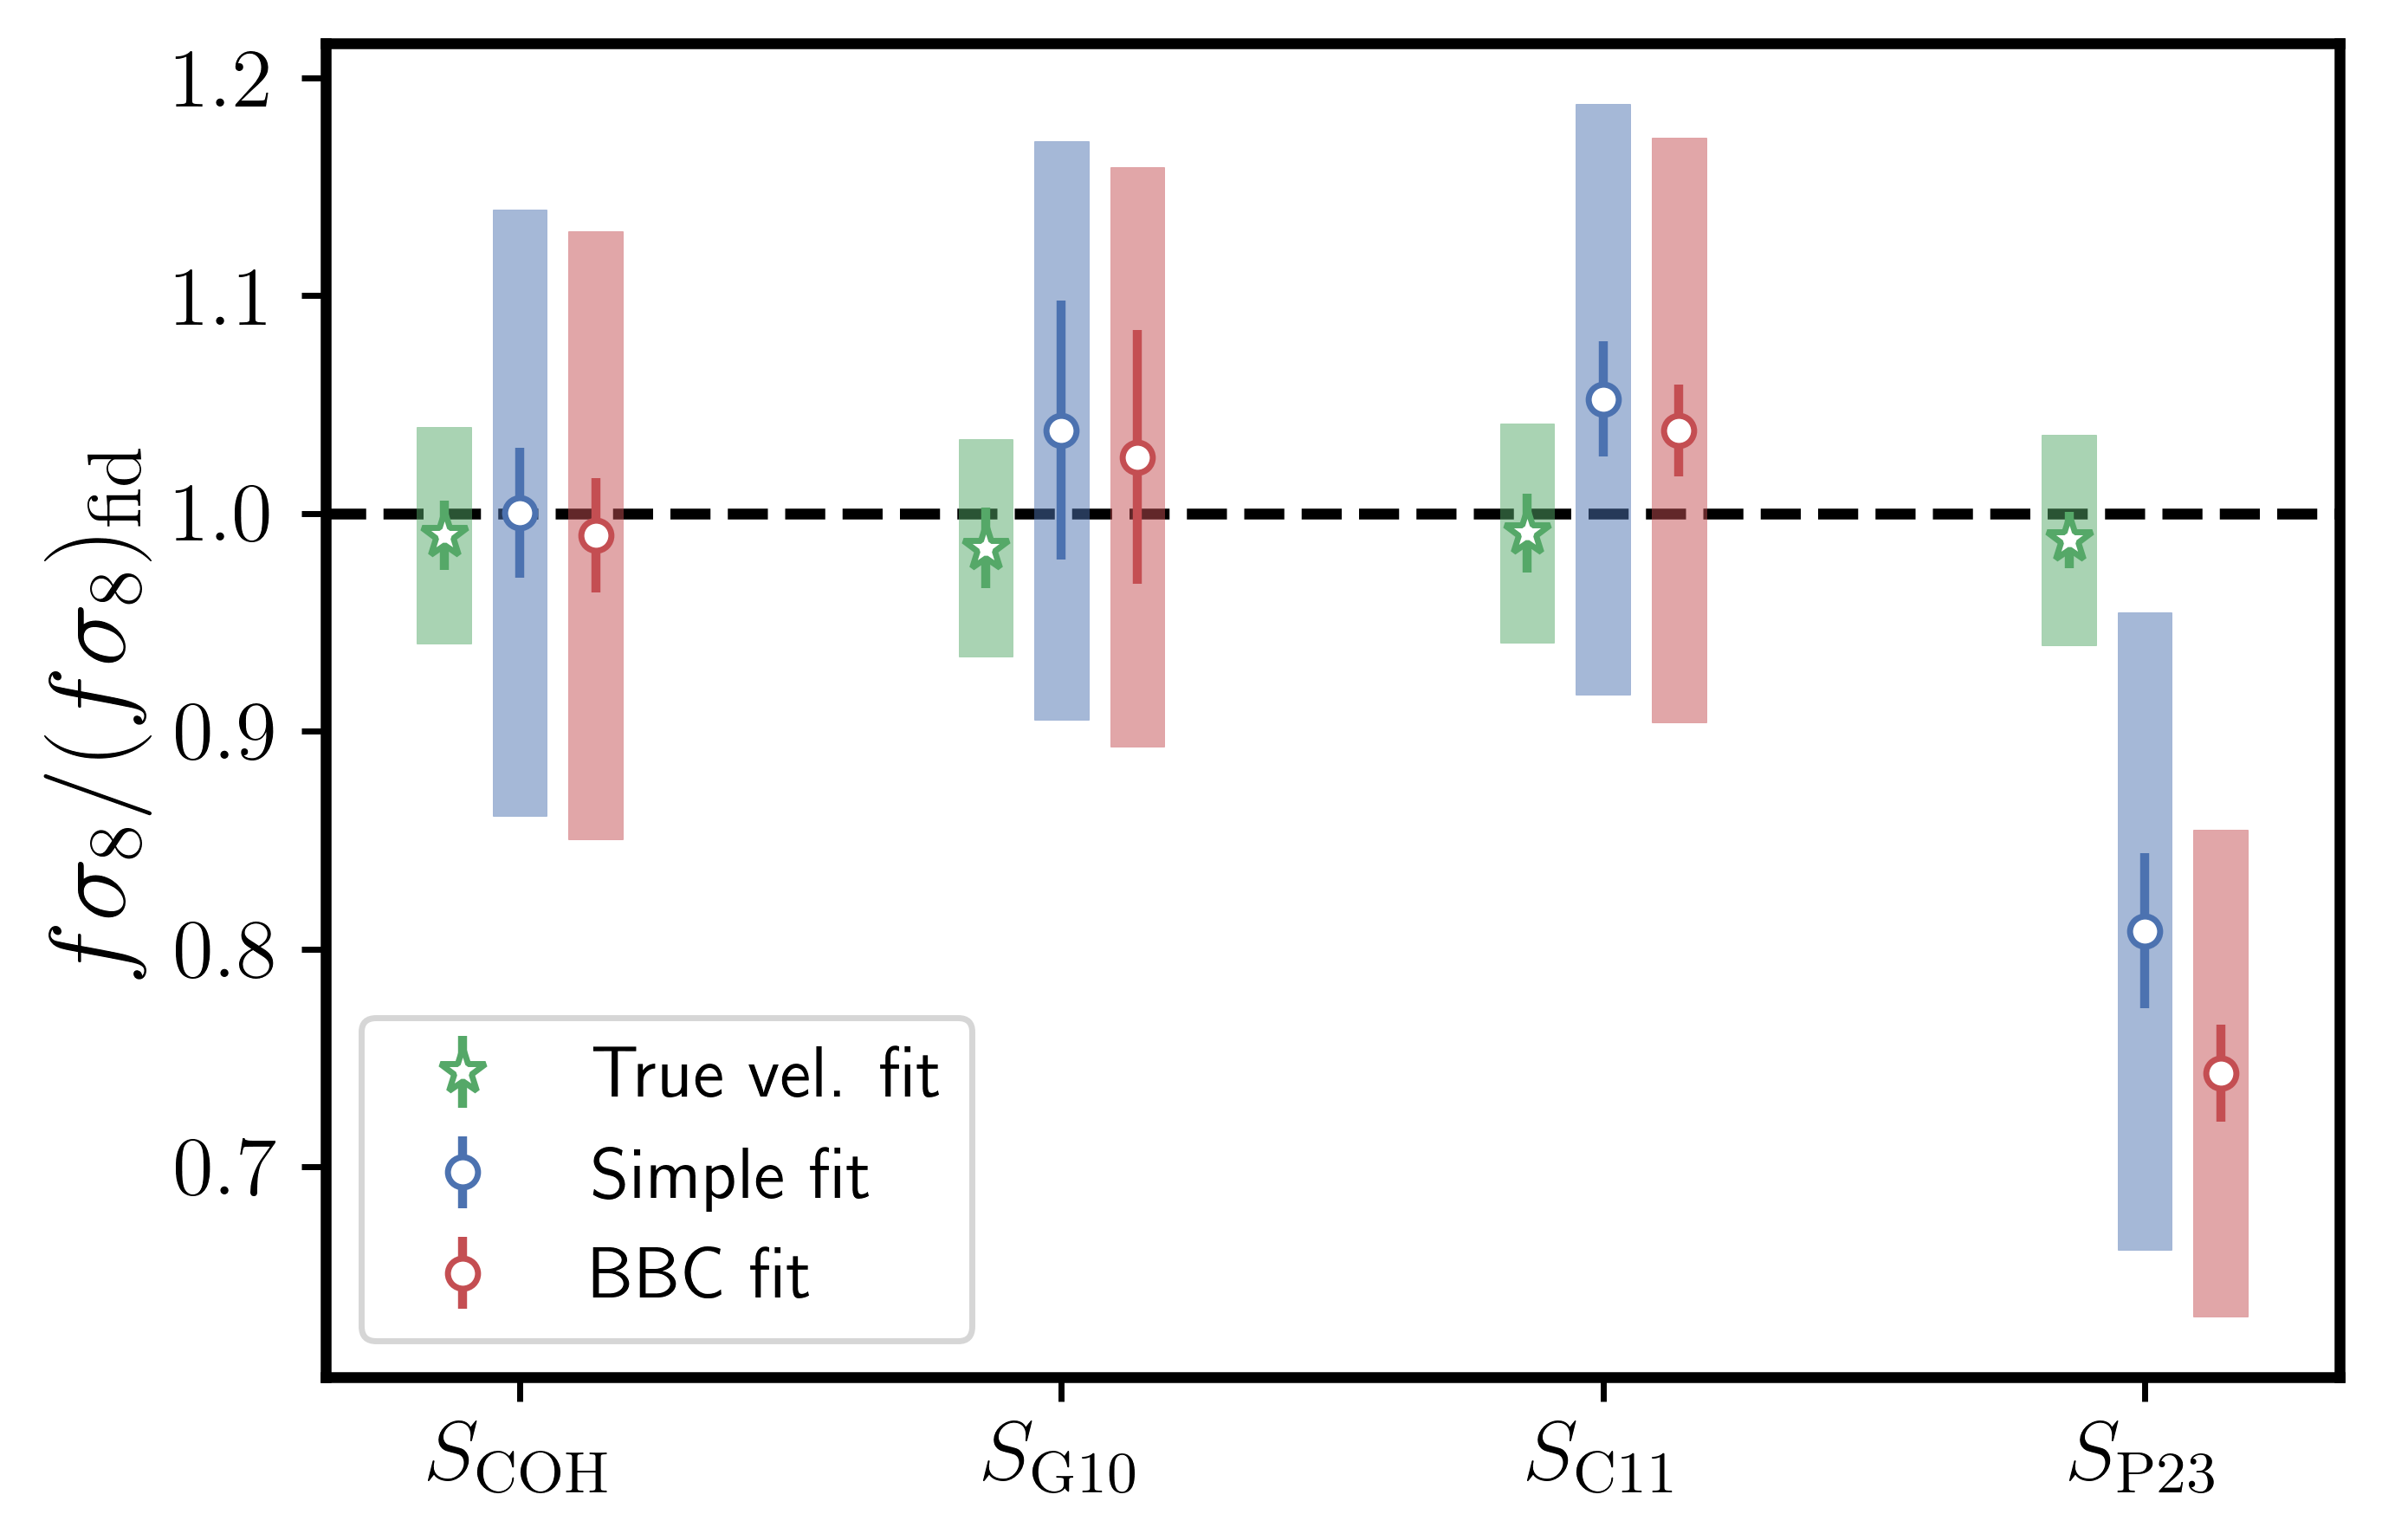

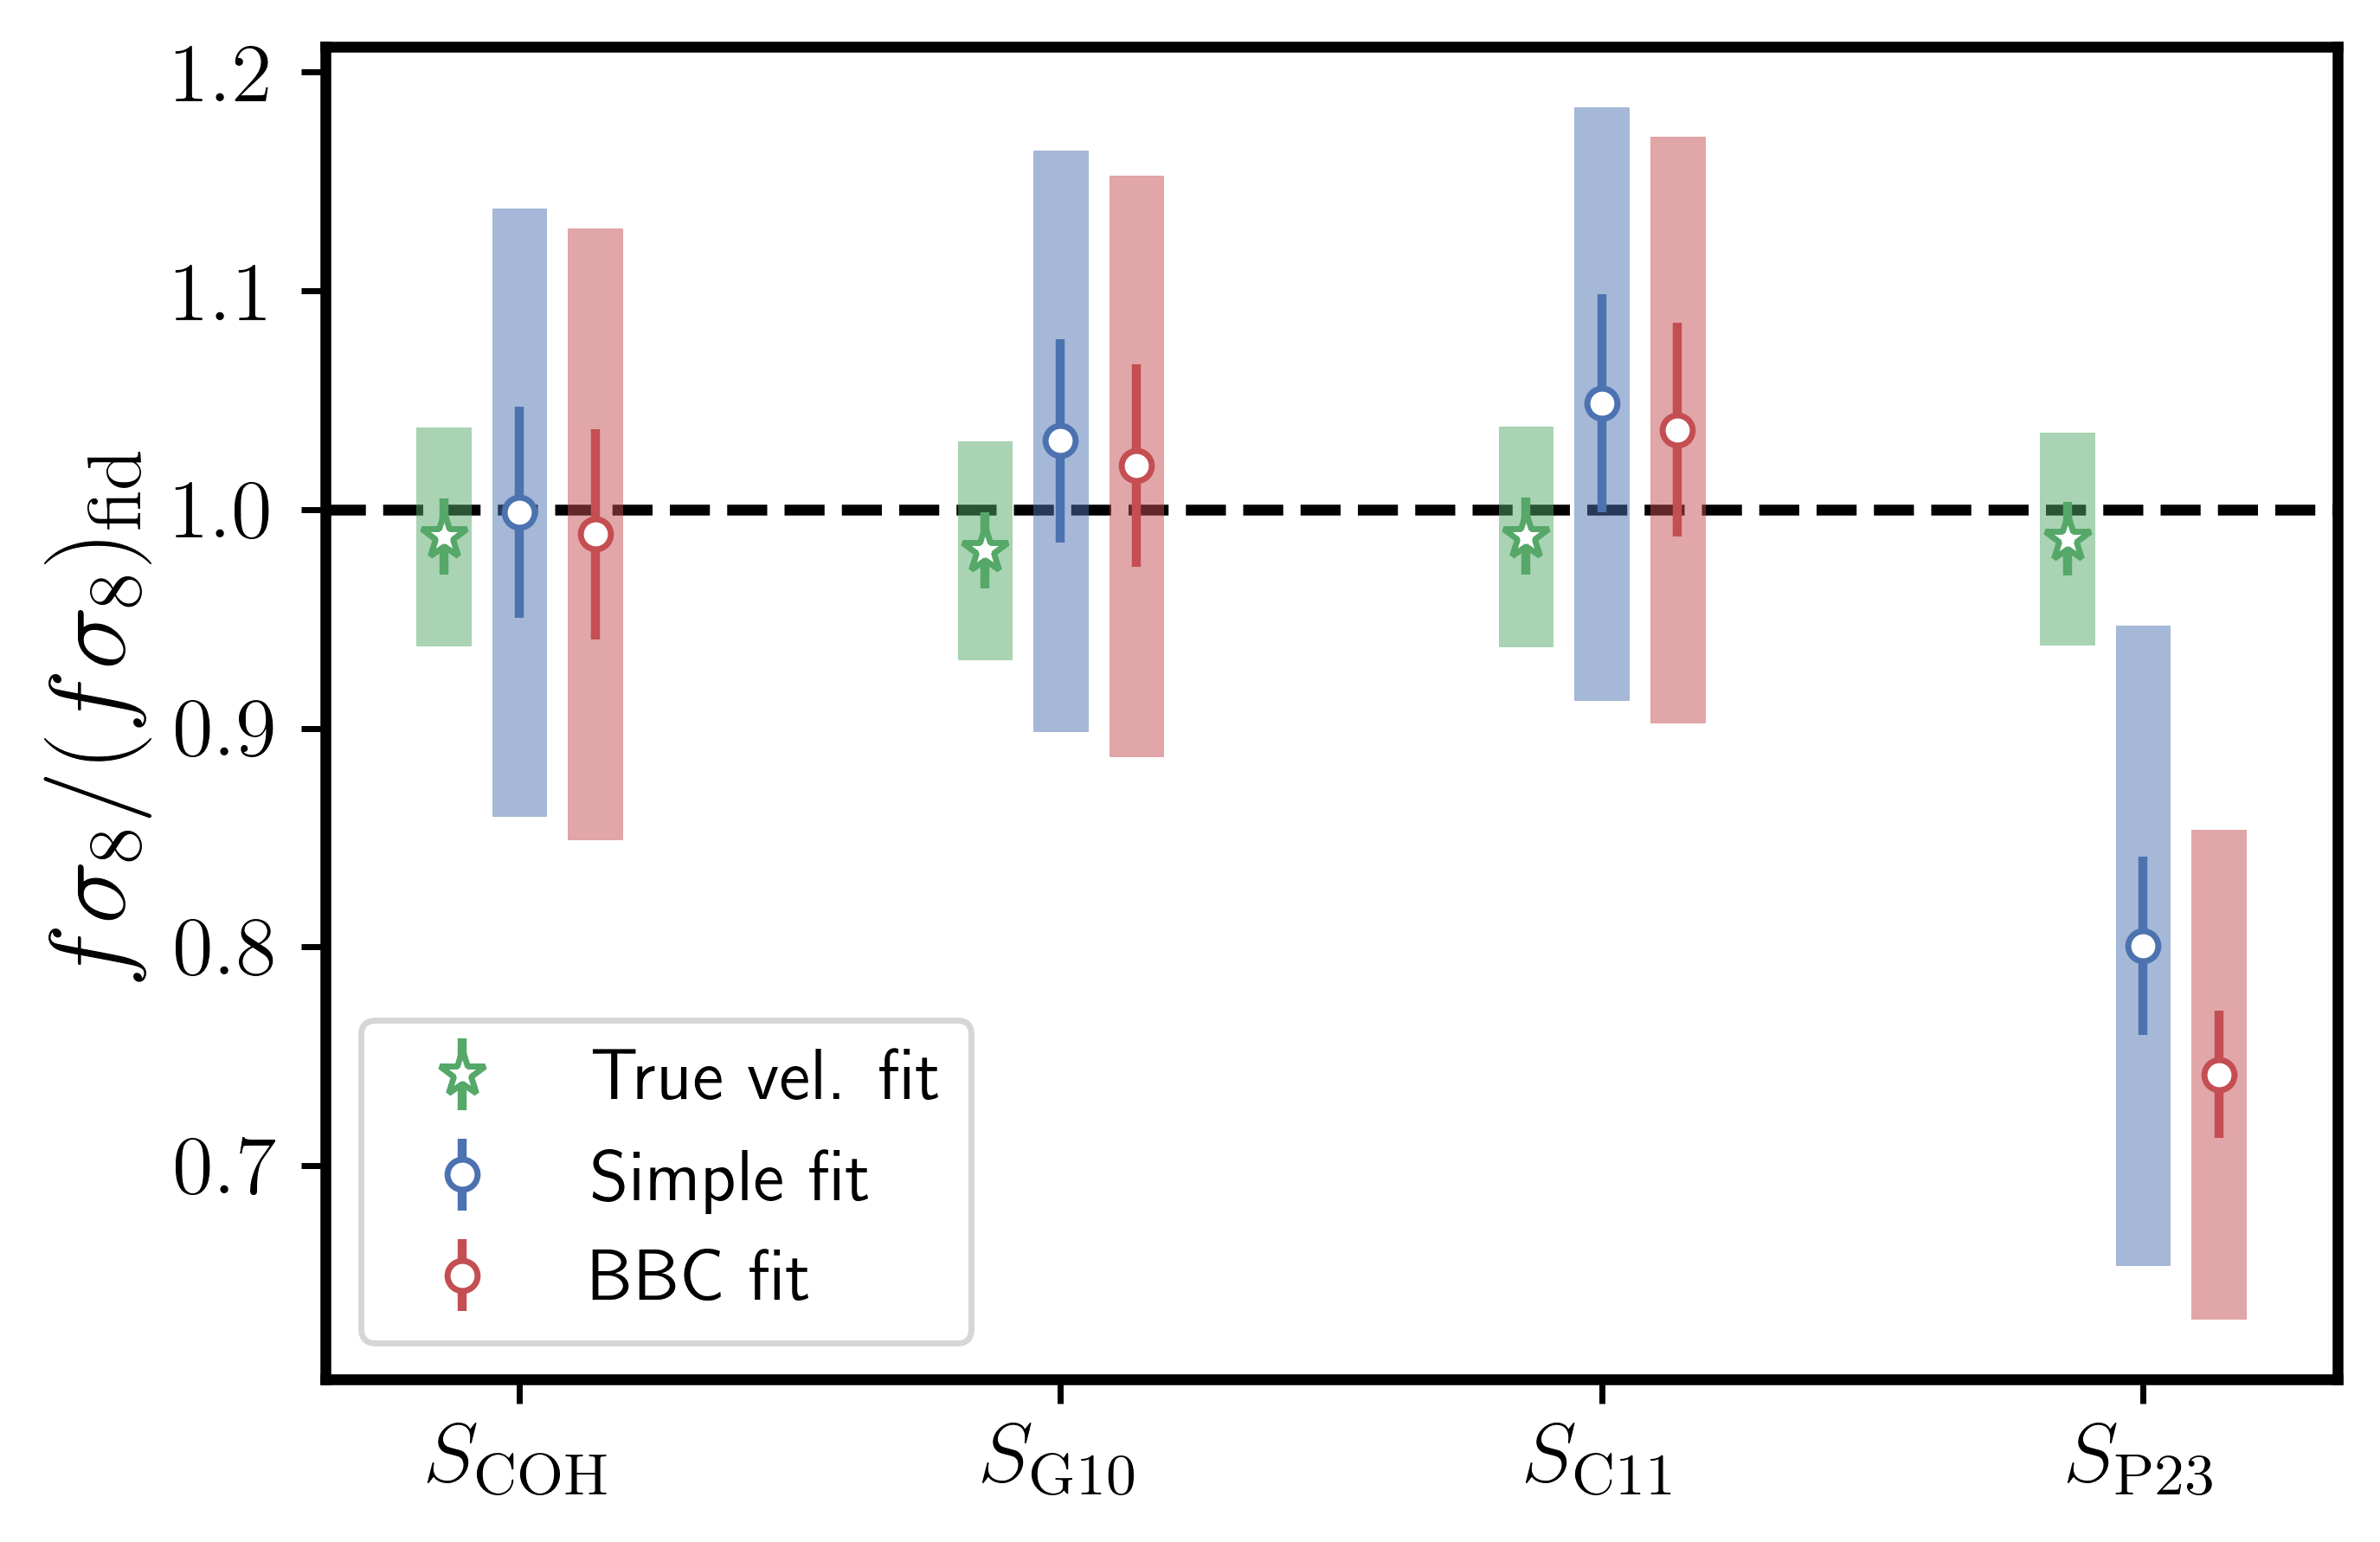

In [7]:
fig1, ax1 = plt.subplots(dpi=500)
fig2, ax2 = plt.subplots(dpi=500)
lines = []
for i, M in enumerate(['RNDSMEAR', 'G10' , 'C11' , 'P21']):
    g = grp_models.get_group(M)
    label0 = label1 = label2 = None
    if i==0:
        label0 = 'True vel. fit'
        label1 = 'BBC fit'
        label2 = 'Simple fit'
 
    if M == 'RNDSMEAR':
        lmod = '\simu{COH}'
    else:
        lmod= '\simu{'+ M +'}'
        
    # -- TRUE
    WMEAN_FS8_ERROR_TRUE = np.sqrt(1 /  np.sum(1 / g.fs8_ERR_TRUE**2))
    WMEAN_FS8_TRUE = np.sum(g.fs8_TRUE * 1 / g.fs8_ERR_TRUE**2) * WMEAN_FS8_ERROR_TRUE**2
    
    MEAN_FS8_TRUE = g.fs8_TRUE.mean()
    STD_FS8_TRUE = g.fs8_TRUE.std() 
    MEAN_FS8_ERROR_TRUE = STD_FS8_TRUE / np.sqrt(len(g))
     
    MEANERROR_FS8_TRUE = np.sqrt(((g.fs8_ERR_TRUE / g.fs8_TRUE)**2).mean())
    
    # -- BBC
    WMEAN_FS8_ERROR_BBC = np.sqrt(1 /  np.sum(1 / g.fs8_ERR_BBC**2))
    WMEAN_FS8_BBC = np.sum(g.fs8_BBC * 1 / g.fs8_ERR_BBC**2) * WMEAN_FS8_ERROR_BBC**2
    
    MEAN_FS8_BBC = g.fs8_BBC.mean()
    STD_FS8_BBC = g.fs8_BBC.std()
    MEAN_FS8_ERROR_BBC = STD_FS8_BBC / np.sqrt(len(g))

    MEANERROR_FS8_BBC = np.sqrt(((g.fs8_ERR_BBC / g.fs8_BBC)**2).mean())
    
    # -- STDFIT
    WMEAN_FS8_ERROR_STDFIT = np.sqrt(1 /  np.sum(1 / g.fs8_ERR_STDFIT**2))
    WMEAN_FS8_STDFIT = np.sum(g.fs8_STDFIT * 1 / g.fs8_ERR_STDFIT**2) * WMEAN_FS8_ERROR_STDFIT**2
    
    MEAN_FS8_STDFIT = g.fs8_STDFIT.mean()
    STD_FS8_STDFIT = g.fs8_STDFIT.std()
    MEAN_FS8_ERROR_STDFIT = STD_FS8_STDFIT / np.sqrt(len(g))

    MEANERROR_FS8_STDFIT = np.sqrt(((g.fs8_ERR_STDFIT / g.fs8_STDFIT)**2).mean())

    lines.append(fs8_res(
        lmod, 
        MEAN_FS8_TRUE, MEAN_FS8_ERROR_TRUE, MEANERROR_FS8_TRUE * 100, STD_FS8_TRUE / MEAN_FS8_TRUE * 100,
        MEAN_FS8_STDFIT, MEAN_FS8_ERROR_STDFIT, MEANERROR_FS8_STDFIT * 100, STD_FS8_STDFIT / MEAN_FS8_STDFIT * 100,
        MEAN_FS8_BBC, MEAN_FS8_ERROR_BBC, MEANERROR_FS8_BBC * 100, STD_FS8_BBC / MEAN_FS8_BBC * 100,
                    )
                )
    
    ax1.errorbar(i-0.14, MEAN_FS8_TRUE, yerr=MEAN_FS8_ERROR_TRUE, fmt='*', lw=1.5, mew=1, mfc='w', ms=8, c='C1', label=label0)
    ax1.errorbar(i, MEAN_FS8_STDFIT, yerr= MEAN_FS8_ERROR_STDFIT, fmt='o', lw=1.5, mew=1, mfc='w', ms=5, c='C0', label=label2)
    ax1.errorbar(i+0.14, MEAN_FS8_BBC, yerr=MEAN_FS8_ERROR_BBC, fmt='o', lw=1.5, mew=1, mfc='w', ms=5, c='C2', label=label1)

    ax1.fill_between([i-0.14-0.05, i-0.14+0.05], MEAN_FS8_TRUE - MEANERROR_FS8_TRUE, MEAN_FS8_TRUE + MEANERROR_FS8_TRUE, alpha=0.5, color='C1',lw=0.1)
    ax1.fill_between([i-0.05, i+0.05], MEAN_FS8_STDFIT - MEANERROR_FS8_STDFIT, MEAN_FS8_STDFIT + MEANERROR_FS8_STDFIT, alpha=0.5, color='C0',lw=0.1)
    ax1.fill_between([i+0.14-0.05, i+0.14+0.05], MEAN_FS8_BBC - MEANERROR_FS8_BBC, MEAN_FS8_BBC + MEANERROR_FS8_BBC, alpha=0.5, color='C2',lw=0.1)

    
    ax2.errorbar(i-0.14, WMEAN_FS8_TRUE, yerr=WMEAN_FS8_ERROR_TRUE, fmt='*', lw=1.5, mew=1, mfc='w', ms=8, c='C1', label=label0)
    ax2.errorbar(i, WMEAN_FS8_STDFIT, yerr=WMEAN_FS8_ERROR_STDFIT, fmt='o', lw=1.5, mew=1, mfc='w', ms=5, c='C0', label=label2)
    ax2.errorbar(i+0.14, WMEAN_FS8_BBC, yerr=WMEAN_FS8_ERROR_BBC, fmt='o', lw=1.5, mew=1, mfc='w', ms=5, c='C2', label=label1)

    ax2.fill_between([i-0.14-0.05, i-0.14+0.05], WMEAN_FS8_TRUE - MEANERROR_FS8_TRUE, WMEAN_FS8_TRUE + MEANERROR_FS8_TRUE, alpha=0.5, color='C1',lw=0.1)
    ax2.fill_between([i-0.05, i+0.05], WMEAN_FS8_STDFIT - MEANERROR_FS8_STDFIT, WMEAN_FS8_STDFIT + MEANERROR_FS8_STDFIT, alpha=0.5, color='C0',lw=0.1)
    ax2.fill_between([i+0.14-0.05, i+0.14+0.05], WMEAN_FS8_BBC - MEANERROR_FS8_BBC, WMEAN_FS8_BBC + MEANERROR_FS8_BBC, alpha=0.5, color='C2',lw=0.1)
    
    
    print(f'#### MODEL: {M} ####\n\n')
    print(f'<N FIT> = {g.NSN.mean():.0f}\n')
        
    print(f'<FS8 TRUE> = {MEAN_FS8_TRUE:.3f} +/- {MEAN_FS8_ERROR_TRUE:.3f}')   
    print(f'<FS8 STDFIT> = {MEAN_FS8_STDFIT:.3f} +/- {MEAN_FS8_ERROR_STDFIT:.3f}')
    print(f'<FS8 BBC> = {MEAN_FS8_BBC:.3f} +/- {MEAN_FS8_ERROR_BBC:.3f} \n\n')
    
    print(f'<FS8 TRUE>_W = {WMEAN_FS8_TRUE:.3f} +/- {WMEAN_FS8_ERROR_TRUE:.3f}')
    print(f'<FS8 STDFIT>_W = {WMEAN_FS8_STDFIT:.3f} +/- {WMEAN_FS8_ERROR_STDFIT:.3f}')
    print(f'<FS8 BBC>_W = {WMEAN_FS8_BBC:.3f} +/- {WMEAN_FS8_ERROR_BBC:.3f} \n\n')
    
    print(f'<SIGMA FS8 TRUE> = {MEAN_FS8_ERROR_TRUE:.3f}')
    print(f'<SIGMA FS8 STDFIT> = {MEANERROR_FS8_STDFIT:.3f}')
    print(f'<SIGMA FS8 BBC> = {MEANERROR_FS8_BBC:.3f}\n\n')
    
    print(f'STD(FS8 TRUE) = {STD_FS8_TRUE:.3f}')
    print(f'STD(FS8 STDFIT) = {STD_FS8_STDFIT:.3f}')
    print(f'STD(FS8 BBC) = {STD_FS8_BBC:.3f}')


    print('-----\n')

labels = [
    r'$S_\mathrm{COH}$', 
    r'$S_\mathrm{G10}$', 
    r'$S_\mathrm{C11}$', 
    r'$S_\mathrm{P23}$']

ax1.set_xticks(ticks=[0,1,2,3], labels=labels);

ax1.axhline(1, ls='--', c='k', zorder=-1)
ax1.legend(loc='lower left')
ax1.set_ylabel('$f\sigma_8/(f\sigma_8)_\mathrm{fid}$')
fig1.savefig('../Figures/Resfs8.pdf', dpi=None)    

ax2.set_xticks(ticks=[0,1,2,3], labels=labels);
ax2.axhline(1, ls='--', c='k', zorder=-1)
ax2.legend(loc='lower left')
ax2.set_ylabel('$f\sigma_8/(f\sigma_8)_\mathrm{fid}$')
fig2.savefig('../Figures/Resfs8_w.pdf', dpi=None)    

TABLE = FS8_RESULT_TABLE_HEADER
for l in lines:
    TABLE += '\n'
    TABLE += l
    TABLE += r'\\'
TABLE += FS8_RESULT_TABLE_FOOTER
print(TABLE)

<N FIT> = 6631

<FS8 TRUE> = 0.988 +/ - 0.014
<FS8 TRUE>_W = 0.986 +/- 0.017
<SIGMA FS8 TRUE> = 0.049
STD(FS8 TRUE) = 0.040


<FS8 STDFIT> = 0.716 +/ - 0.026
<FS8 STDFIT>_W = 0.713 +/- 0.039
<SIGMA FS8 STDFIT> = 0.157
STD(FS8 STDFIT) = 0.075


<FS8 BBC> = 0.650 +/ - 0.017
<FS8 BBC>_W = 0.649 +/- 0.028
<SIGMA FS8 BBC> = 0.122
STD(FS8 BBC) = 0.049


<FS8 BBCCOV> = 0.648 +/ - 0.015
<FS8 BBCCOV>_W = 0.647 +/- 0.028
<SIGMA FS8 BBCCOV> = 0.121
STD(FS8 BBCCOV) = 0.043




/tmp/ipykernel_1102368/2669072810.py:116: UserWarning: Legend does not support handles for Annotation instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  ax.legend(handles, labels)


\begin{table*}
    \centering
    \renewcommand{\arraystretch}{2}
    
    \begin{tabular}{c||c|c}
        & $\langle\fsig\rangle / \left(\fsig\right)_\mathrm{fid}$ & $\sqrt{\langle\sigma_{\fsig}^2\rangle} $ \\ 
        \hhline{=::==}
        True fit & 0.9865 $\pm$ 0.0170 & 4.89\%\\
        Simple fit & 0.7130 $\pm$ 0.0389 & 15.69\%\\
        BBC fit & 0.6491 $\pm$ 0.0277 & 12.17\%\\
        BBC + int. scat. cov fit & 0.6473 $\pm$ 0.0276 & 12.14\%\\
    \end{tabular}
\end{table*}

Average shift: -0.19 %
Average delta: nan %
Percentage of variance:  -0.8649698020385241


/tmp/ipykernel_1102368/2669072810.py:132: RuntimeWarning: invalid value encountered in sqrt
  print(f'Average delta: {np.sqrt(np.mean(delta_2/ g.fs8_BBC**2))*100:.2f} %')


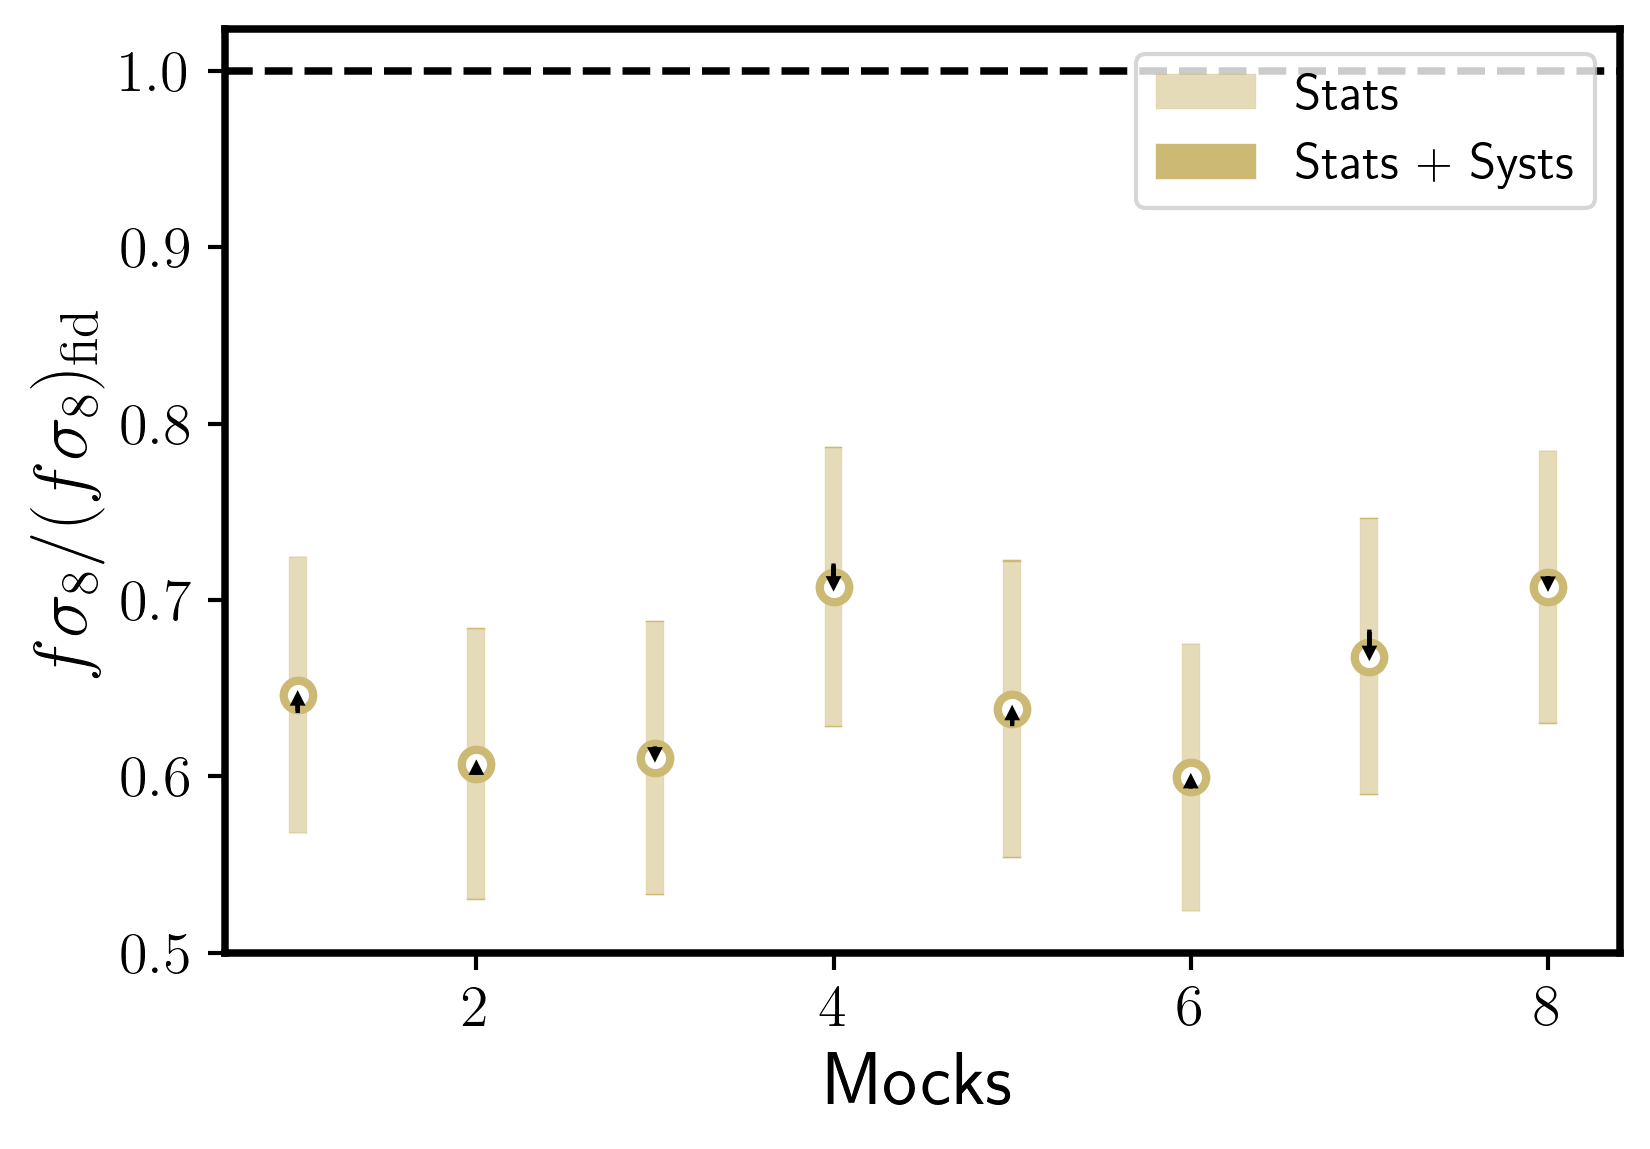

In [8]:
from matplotlib.lines import Line2D
from matplotlib.patches import Arrow

color = 'C4'

fig, ax = plt.subplots(dpi=300)

g = res_P21_intsct_df

# -- TRUE
WMEAN_FS8_ERROR_TRUE = np.sqrt(1 /  np.sum(1 / g.fs8_ERR_TRUE**2))
WMEAN_FS8_TRUE = np.sum(g.fs8_TRUE * 1 / g.fs8_ERR_TRUE**2) * WMEAN_FS8_ERROR_TRUE**2
    
MEAN_FS8_TRUE = g.fs8_TRUE.mean()
STD_FS8_TRUE = g.fs8_TRUE.std() 
MEAN_FS8_ERROR_TRUE = STD_FS8_TRUE / np.sqrt(len(g))
     
MEANERROR_FS8_TRUE = np.sqrt(((g.fs8_ERR_TRUE / g.fs8_TRUE)**2).mean())
    
# -- BBC
WMEAN_FS8_ERROR_BBC = np.sqrt(1 /  np.sum(1 / g.fs8_ERR_BBC**2))
WMEAN_FS8_BBC = np.sum(g.fs8_BBC * 1 / g.fs8_ERR_BBC**2) * WMEAN_FS8_ERROR_BBC**2
  
MEAN_FS8_BBC = g.fs8_BBC.mean()
STD_FS8_BBC = g.fs8_BBC.std()
MEAN_FS8_ERROR_BBC = STD_FS8_BBC / np.sqrt(len(g))

MEANERROR_FS8_BBC = np.sqrt(((g.fs8_ERR_BBC / g.fs8_BBC)**2).mean())
   
# -- BBC COV
WMEAN_FS8_ERROR_BBCCOV = np.sqrt(1 /  np.sum(1 / g.fs8_ERR_BBCCOV**2))
WMEAN_FS8_BBCCOV = np.sum(g.fs8_BBCCOV * 1 / g.fs8_ERR_BBCCOV**2) * WMEAN_FS8_ERROR_BBCCOV**2

MEAN_FS8_BBCCOV = g.fs8_BBCCOV.mean()
STD_FS8_BBCCOV = g.fs8_BBCCOV.std()
MEAN_FS8_ERROR_BBCCOV = STD_FS8_BBCCOV / np.sqrt(len(g))

MEANERROR_FS8_BBCCOV = np.sqrt(((g.fs8_ERR_BBCCOV / g.fs8_BBCCOV)**2).mean())
    
# -- STDFIT
WMEAN_FS8_ERROR_STDFIT = np.sqrt(1 /  np.sum(1 / g.fs8_ERR_STDFIT**2))
WMEAN_FS8_STDFIT = np.sum(g.fs8_STDFIT * 1 / g.fs8_ERR_STDFIT**2) * WMEAN_FS8_ERROR_STDFIT**2
    
MEAN_FS8_STDFIT = g.fs8_STDFIT.mean()
STD_FS8_STDFIT = g.fs8_STDFIT.std()
MEAN_FS8_ERROR_STDFIT = STD_FS8_STDFIT / np.sqrt(len(g))

MEANERROR_FS8_STDFIT = np.sqrt(((g.fs8_ERR_STDFIT / g.fs8_STDFIT)**2).mean())

print(f'<N FIT> = {g.NSN.mean():.0f}\n')

lines = []
for M, l in zip(['TRUE', 'STDFIT', 'BBC', 'BBCCOV'],
                ['True fit', 'Simple fit', 'BBC fit', 'BBC + int. scat. cov fit']):

    print(f"<FS8 {M}> = {eval(f'MEAN_FS8_{M}'):.3f} +/ - {eval(f'MEAN_FS8_ERROR_{M}'):.3f}") 
    print(f"<FS8 {M}>_W = {eval(f'WMEAN_FS8_{M}'):.3f} +/- {eval(f'WMEAN_FS8_ERROR_{M}'):.3f}") 
    print(f"<SIGMA FS8 {M}> = {eval(f'MEANERROR_FS8_{M}'):.3f}")
    print(f"STD(FS8 {M}) = {eval(f'STD_FS8_{M}'):.3f}\n\n")
    lines.append(
        fs8sys_res(
            l, 
            eval(f'WMEAN_FS8_{M}'), 
            eval(f'WMEAN_FS8_ERROR_{M}'), 
            eval(f'MEANERROR_FS8_{M}') * 100
        )
    )


for i in range(8):
    if i == 0:
        labelStatSys = 'Stats + Systs'
        labelStat = 'Stats'
        labelArr = r'$\Delta f\sigma_8$'
    else:
        labelStatSys = None
        labelStat = None
        labelArr = None
    plt.fill_between([i-0.05+1, i+0.05+1], 
                     res_P21_intsct_df.fs8_BBCCOV.values[i] + res_P21_intsct_df.fs8_ERR_BBC.values[i], 
                     res_P21_intsct_df.fs8_BBCCOV.values[i] - res_P21_intsct_df.fs8_ERR_BBC.values[i], 
                     alpha=0.5, color=color,lw=0.1, 
                     label=labelStat)
    
    plt.fill_between([i-0.05+1, i+0.05+1], 
                     res_P21_intsct_df.fs8_BBCCOV.values[i] + res_P21_intsct_df.fs8_ERR_BBC.values[i], 
                     res_P21_intsct_df.fs8_BBCCOV.values[i] + res_P21_intsct_df.fs8_ERR_BBCCOV.values[i], 
                     alpha=1, 
                     color=color,
                     lw=0.1,
                     label=labelStatSys)
    
    plt.fill_between([i-0.05+1, i+0.05+1], 
                    res_P21_intsct_df.fs8_BBCCOV.values[i] - res_P21_intsct_df.fs8_ERR_BBC.values[i], 
                     res_P21_intsct_df.fs8_BBCCOV.values[i] - res_P21_intsct_df.fs8_ERR_BBCCOV.values[i], 
                     alpha=1, 
                     color=color,
                     lw=0.1, 
                     label=None)
    plt.scatter(i+1, res_P21_intsct_df.fs8_BBCCOV.values[i], edgecolor=color, s=50, marker='o', facecolor='white', linewidths=2)
    

    plt.arrow(i+1, res_P21_intsct_df.fs8_BBC.values[i], 0, res_P21_intsct_df.fs8_BBCCOV.values[i] - res_P21_intsct_df.fs8_BBC.values[i] ,
              length_includes_head=True,
          head_width=0.05, head_length=0.005, color='k')

plt.ylabel('$f\sigma_8/(f\sigma_8)_\mathrm{fid}$')
plt.xlabel('Mocks')


# Add the arrow patch to the legend
handles, labels = ax.get_legend_handles_labels()
handles.append(ax.annotate("", xy=(0, 0), xytext=(0, 0), arrowprops=dict(arrowstyle="->")))
labels.append("My Arrow")

ax.legend(handles, labels)
ax.axhline(1, ls='--', c='k')

plt.savefig('../Figures/fs8sys.pdf', bbox_inches='tight')

TABLE = FS8SYS_RESULT_TABLE_HEADER
for l in lines:
    TABLE += '\n'
    TABLE += ' ' * 8 + l
    TABLE += r'\\'
TABLE += '\n' + FS8SYS_RESULT_TABLE_FOOTER
print(TABLE)

delta_2 = ((g.fs8_ERR_BBCCOV / g.fs8_BBCCOV)**2 - (g.fs8_ERR_BBC / g.fs8_BBC)**2) 
shift = (g.fs8_BBCCOV - g.fs8_BBC) /  g.fs8_BBC * 100
print(f'Average shift: {shift.mean():.2f} %')
print(f'Average delta: {np.sqrt(np.mean(delta_2/ g.fs8_BBC**2))*100:.2f} %')
print('Percentage of variance: ', np.mean(delta_2 / g.fs8_ERR_BBCCOV**2) * 100)



## PV estimations

In [9]:
mock_dic = {}
for mock in np.arange(8):
    print(f'Processing mock {mock}')
    MOCK_DIR = PIPPIN_DIR / f'LSST_UCHUU_MOCK{mock:02d}_BC'

    BBC_DIR = MOCK_DIR / '6_BIASCOR'
    FIT_DIR =  MOCK_DIR / '2_LCFIT'
    zrange = [0.02, 0.1]

    # Open files
    data_fit = {}
    par_fit = {}
    par_BBC = {}
    data_bbc = {}
    for k, g in grp_models:
        sg = g.loc[mock]

        # BBC DATA
        BBC_FILE = BBC_DIR / f'LSST_{k}/output/OUTPUT_BBCFIT/FITOPT000_MUOPT000.FITRES.gz'
        df_BBC = ascii.read(BBC_FILE).to_pandas().set_index('CIDint')
        
        # STANDARD DATA
        FIT_FILE = FIT_DIR /  f'LSST_FIT_LSST_{k}/output/PIP_LSST_UCHUU_MOCK{mock:02d}_BC_LSST_{k}/FITOPT000.FITRES.gz'
        df_STDFIT = ascii.read(FIT_FILE).to_pandas().set_index('CID')
        df_STDFIT = df_STDFIT.loc[df_BBC.index]
        
        mask = ((df_BBC["HOST_NMATCH"] > 0) & (df_BBC['zHD'].between(zrange[0], zrange[1])) & (df_STDFIT.apply(pf.positive_def, axis=1))).values
      
        df_BBC = df_BBC[mask]
        df_STDFIT = df_STDFIT[mask]
        df_STDFIT = df_STDFIT.apply(pf.x0_to_mB_err, axis=1)
        
        data_bbc[k] = flip.data_vector.basic.VelFromHDres(
            {
                "ra": np.deg2rad(df_BBC['HOST_RA'].values),
                "dec": np.deg2rad(df_BBC['HOST_DEC'].values),
                "dmu": df_BBC['MU'].values - cosmo.distmod(df_BBC['zCMB'].values).value,
                "dmu_error": df_BBC['MUERR'].values,
                "zobs": df_BBC['zCMB'].values,
                "rcom_zobs": cosmo.comoving_distance(df_BBC["zCMB"].values).value * cosmo.h,
                "hubble_norm": 100 * cosmo.efunc(df_BBC["zCMB"].values),
                "x1": df_BBC["x1"].values,
                "c": df_BBC["c"].values,
                "mb": df_BBC['mB'].values ,
                "vtrue": df_BBC['SIM_HOSTLIB_VPEC'].values
            }, 
            vel_estimator="full"
            )
        
        par_BBC[k] = {'M_0': sg['M_0_BBC'].values[0]}


        data_fit[k] = flip.data_vector.snia_vectors.VelFromSALTfit({
            "ra": np.deg2rad(df_STDFIT['HOST_RA'].values),
            "dec": np.deg2rad(df_STDFIT['HOST_DEC'].values),
            "mb": df_STDFIT['mB'].values ,
            "x1": df_STDFIT["x1"].values,
            "c": df_STDFIT["c"].values,
            "e_mb": df_STDFIT["mBERR"].values,
            "e_x1": df_STDFIT["x1ERR"].values,
            "e_c": df_STDFIT["cERR"].values,
            "cov_mb_x1": df_STDFIT["COV_mB_x1"].values,
            "cov_mb_c": df_STDFIT["COV_mB_c"].values,
            "cov_x1_c": df_STDFIT["COV_x1_c"].values,
            "zobs": df_STDFIT["zCMB"].values,
            "rcom_zobs": cosmo.comoving_distance(df_STDFIT["zCMB"].values).value * cosmo.h,
            "hubble_norm": 100 * cosmo.efunc(df_STDFIT["zCMB"].values),
            "host_logmass": df_STDFIT["HOST_LOGMASS"].values,
            "vtrue": df_STDFIT['SIM_HOSTLIB_VPEC'].values,
            }, 
            vel_estimator="full", 
            h=cosmo.h)

        par_fit[k] = {tk: sg[tk+ '_STDFIT'].values[0] for tk in TRIPP_KEYS}

    mock_dic[mock] = {
          'BBC':  data_bbc, 
          'STDFIT': data_fit, 
          'STDFIT_par': par_fit,
          'BBC_par': par_BBC
            }

Processing mock 0
Processing mock 1
Processing mock 2
Processing mock 3
Processing mock 4
Processing mock 5
Processing mock 6
Processing mock 7


In [10]:
all_v_BBC = {
    'G10': [],
    'RNDSMEAR': [],
    'P21': [],
    'C11': []
}

all_verr_BBC = {
    'G10': [],
    'RNDSMEAR': [],
    'P21': [],
    'C11': []
}

all_v_STDFIT = {
    'G10': [],
    'RNDSMEAR': [],
    'P21': [],
    'C11': []
}

all_verr_STDFIT = {
    'G10': [],
    'RNDSMEAR': [],
    'P21': [],
    'C11': []
}

all_dmu_BBC = {
    'G10': [],
    'RNDSMEAR': [],
    'P21': [],
    'C11': []
}

all_dmuerr_BBC = {
    'G10': [],
    'RNDSMEAR': [],
    'P21': [],
    'C11': []
}

all_dmu_STDFIT = {
    'G10': [],
    'RNDSMEAR': [],
    'P21': [],
    'C11': []
}

all_dmuerr_STDFIT = {
    'G10': [],
    'RNDSMEAR': [],
    'P21': [],
    'C11': []
}


keys = ['c', 'vtrue', 'x1', 'zobs']

for k in keys:
    locals()[f"all_{k}_BBC"] = {
        'G10': [],
        'RNDSMEAR': [],
        'P21': [],
        'C11': []
    }
    
    locals()[f"all_{k}_STDFIT"] = {
        'G10': [],
        'RNDSMEAR': [],
        'P21': [],
        'C11': []
    }
    
for m in mock_dic:
    for k in mock_dic[m]['BBC']:
        for v in keys:
            locals()[f"all_{v}_BBC"][k].append(mock_dic[m]['BBC'][k].data[v])
            locals()[f"all_{v}_STDFIT"][k].append(mock_dic[m]['STDFIT'][k].data[v])

        all_dmu_BBC[k].append(mock_dic[m]['BBC'][k].data['dmu'] - mock_dic[m]['BBC_par'][k]['M_0'])
        all_dmuerr_BBC[k].append(mock_dic[m]['BBC'][k].data['dmu_error'])

        v, vvar = mock_dic[m]['BBC'][k](mock_dic[m]['BBC_par'][k])
        all_verr_BBC[k].append(np.sqrt(vvar))
        all_v_BBC[k].append(v)
        
        all_dmu_STDFIT[k].append(mock_dic[m]['STDFIT'][k].compute_distance_modulus_difference(mock_dic[m]['STDFIT_par'][k]))
        all_dmuerr_STDFIT[k].append(np.sqrt(mock_dic[m]['STDFIT'][k].compute_observed_distance_modulus_variance(mock_dic[m]['STDFIT_par'][k])))

        v, vvar = mock_dic[m]['STDFIT'][k](mock_dic[m]['STDFIT_par'][k])
        all_v_STDFIT[k].append(v)
        all_verr_STDFIT[k].append(np.sqrt(vvar))
keys.extend(['v', 'verr', 'dmu', 'dmuerr'])

for k in keys:
    for v in  locals()[f"all_{k}_STDFIT"]:
        locals()[f"all_{k}_STDFIT"][v] = np.hstack(locals()[f"all_{k}_STDFIT"][v])
        locals()[f"all_{k}_BBC"][v] = np.hstack(locals()[f"all_{k}_BBC"][v])



In [11]:
k = 'dmuerr'
for v in  locals()[f"all_{k}_STDFIT"]:
    locals()[f"all_{k}_STDFIT"][v] = np.hstack(locals()[f"all_{k}_STDFIT"][v])
    locals()[f"all_{k}_BBC"][v] = np.hstack(locals()[f"all_{k}_BBC"][v])

In [12]:
def plot_x_v(xkey, xrange=None, yrange=None, n_2d_bins=10, n_1d_bins=10, xlabel=''):
    fig, axs = plt.subplots(2, 2, dpi=200, sharex=True, sharey=True, figsize=(6,6))

    bins = np.linspace(xmin, xmax, n_1d_bins)
    for i, k in enumerate(['RNDSMEAR', 'G10', 'C11', 'P21']):
        add_txt = k
        if k == 'RNDSMEAR':
            add_txt = r'$S_\mathrm{COH}$'
        elif k == 'P21':
            add_txt = r'$S_\mathrm{P23}$'
        else:
            add_txt = r'$S_\mathrm{' + k + '}$'

        if i==0:
            label_bbc = 'BBC fit'
            label_STDFIT = 'Simple fit'
            put_legend = True
        else:
            label_bbc = None
            label_STDFIT = None
            put_legend = False

        # STANDARD METHOD
        mut.plots.plot_density(globals()[f'all_{xkey}_STDFIT'][k], all_v_STDFIT[k] - all_vtrue_STDFIT[k], xrange=[xmin, xmax], yrange=[ymin, ymax], 
                               bins_2d=n_2d_bins, ax=axs[i // 2, i % 2], add_txt=add_txt, levels=[0.25, 0.5, 0.75], smooth=1.5, 
                               label=label_STDFIT,put_legend=put_legend, color='C0', fill=True, ytext=0.9, xtext=0.8)
        
        # sns.kdeplot(x=globals()[f'all_{xkey}_STDFIT'][k], y=all_v_STDFIT[k] - all_vtrue_STDFIT[k],
        #             clip=((xrange[0], xrange[1]), (yrange[0], yrange[1])), levels=[0.25,0.5, 0.75, 1.],
        #             ax=axs[i // 2, i % 2], fill=True, color='C0')
        x, y, yerr, _ = mut.plots.mean_in_bins(globals()[f'all_{xkey}_STDFIT'][k], all_v_STDFIT[k] - all_vtrue_STDFIT[k], bins,
                                            ywerr=all_verr_STDFIT[k])
        print('MODEL ', k)
        print(f"Bias at c=-0.1: {np.interp(-0.1, x,y)}")
        print(f"Bias at c=0.2: {np.interp(0.2, x,y)}")
        print()
        axs[i // 2, i % 2].errorbar(x, y, yerr=yerr, fmt='o', label=label_STDFIT, mew=0.5, mec='k', ms=5)
        
        #x, y, y1q, y3q = mut.plots.median_in_bins(globals()[f'all_{xkey}_STDFIT'][k], all_v_STDFIT[k] - all_vtrue_STDFIT[k], bins)
        
        #axs[i // 2, i % 2].plot(x, y, ls='--', color='C0')
        #axs[i // 2, i % 2].plot(x, y1q, ls='--', color='C0')
        #axs[i // 2, i % 2].plot(x, y3q, ls='--', color='C0')

        # BBC ND
        mut.plots.plot_density(globals()[f'all_{xkey}_BBC'][k], all_v_BBC[k] - all_vtrue_BBC[k], xrange=[xmin, xmax], yrange=[ymin, ymax], bins_2d=n_2d_bins, ax=axs[i // 2, i % 2], add_txt='', 
                               levels=[0.25, 0.5, 0.75], smooth=1.5, color='C2', fill=False, label=label_bbc,put_legend=put_legend, legendfs=8)


        x, y, yerr, _ = mut.plots.mean_in_bins(globals()[f'all_{xkey}_BBC'][k], all_v_BBC[k] - all_vtrue_BBC[k], bins,
                                               ywerr=all_verr_BBC[k])
        axs[i // 2, i % 2].errorbar(x, y, yerr=yerr, fmt='o', label=label_bbc, color='C2', mew=0.5,mec='k', ms=5)
        
        #x, y, y1q, y3q  = mut.plots.median_in_bins(globals()[f'all_{xkey}_BBC'][k], all_v_BBC[k] - all_vtrue_BBC[k], bins)
        #axs[i // 2, i % 2].plot(x, y, ls='--', color='C2')
        
        axs[i // 2, i % 2].axhline(0, ls='--', c='k')

    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.0)

    for ax in axs[1]:
        ax.set_xlabel(xlabel)

    for ax in [axs[0][0], axs[1][0]]:
        ax.set_ylabel(r'$\hat{v} - v_\mathrm{true}$ km s$^{-1}$')

    for ax in axs.flatten():
        ax.set_ylim(ymin, ymax)


MODEL  RNDSMEAR
Bias at c=-0.1: 17.288933287491908
Bias at c=0.2: -10.622994933236942

MODEL  G10
Bias at c=-0.1: 18.924567324859737
Bias at c=0.2: 6.42601122070444

MODEL  C11
Bias at c=-0.1: -475.745438737817
Bias at c=0.2: -46.50843509376625

MODEL  P21
Bias at c=-0.1: -189.96759787621392
Bias at c=0.2: -182.77348790015736



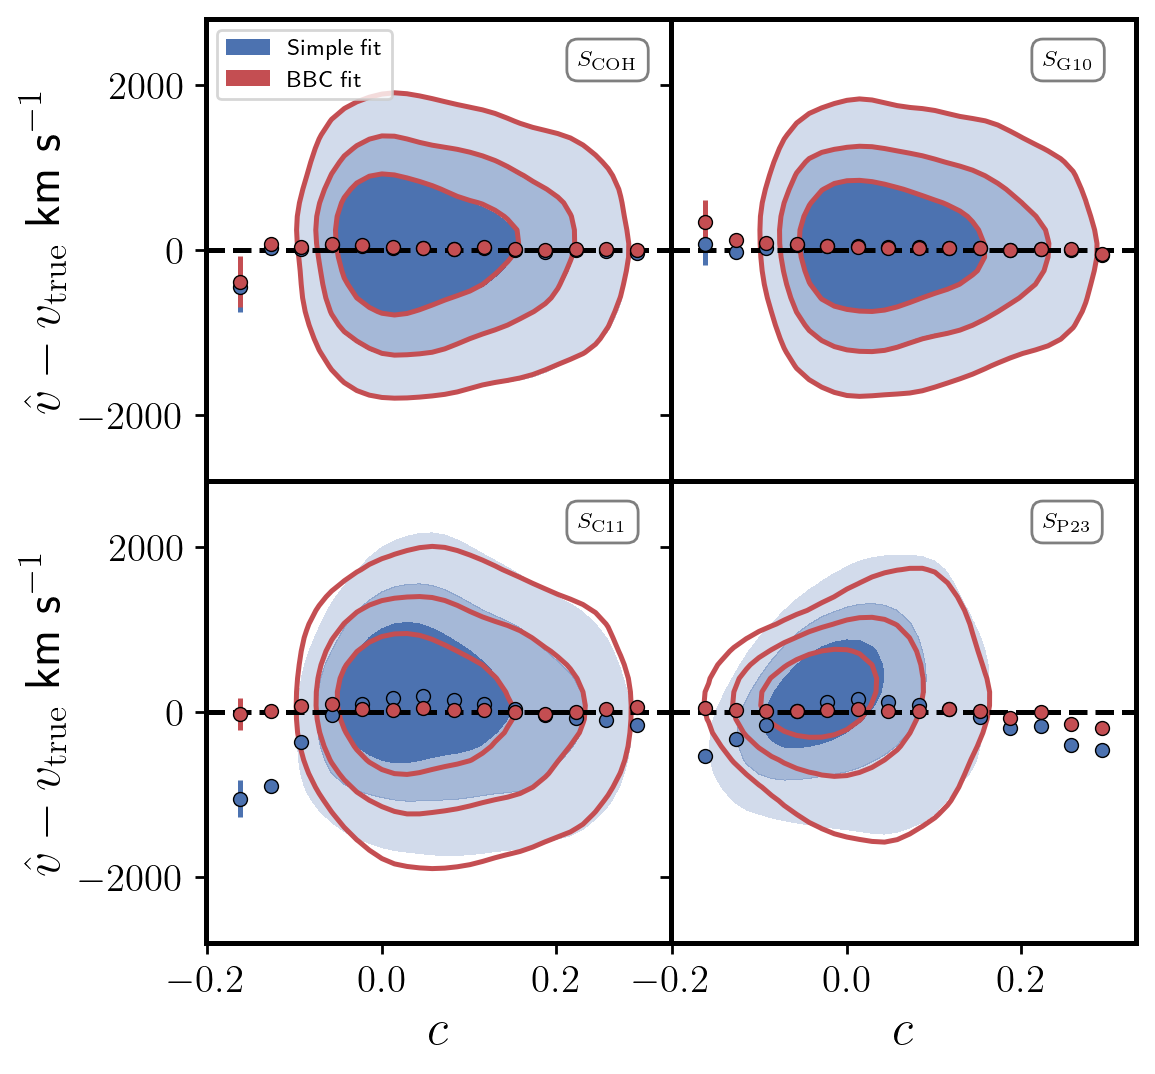

In [13]:
xmin, xmax = -0.18, 0.31
ymin, ymax= -2800, 2800

plot_x_v('c', xrange=[xmin, xmax], yrange=[ymin, ymax], n_2d_bins=35, n_1d_bins=15, xlabel=r'$c$')

plt.savefig('../Figures/Vbias_c.pdf', dpi=None, bbox_inches='tight')

In [14]:
def plot_hists(data_BBC, data_STDFIT, bins=None, xrange=None, filename='test.pdf', save=True, density=False, xlabel='', 
               plot_gauss=False, tformat='.3f', tunit=None, tpos=(0.6, 0.8), ticks_fs=None, label_fs=18, text_fs=None, nonGauss=False, xlim=None, ylim=None):
    fig, axs = plt.subplots(2, 2, dpi=200, sharex=True, sharey=True, figsize=(9,9))
    
    for i, k in enumerate(['RNDSMEAR', 'G10', 'C11', 'P21']):
        ktext = r'S_\mathrm{' + k + '}'
        if k == 'RNDSMEAR':
            ktext=r'S_\mathrm{COH}'
        if k=='P21':
            ktext=r'S_\mathrm{P23}'
        if i==0:
            label_bbc = 'BBC fit'
            label_STDFIT = 'Simple fit'
        else:
            label_bbc = None
            label_STDFIT = None
        ktext +=  r'\vspace{0.5cm}'

        print(f'#### MODEL: {ktext} ####\n')
        
        print(f'N DATA = {len(data_BBC[k]) / 8}')

        print(f'MEAN STDFIT = {np.mean(data_STDFIT[k])}')
        print(f'MEAN BBC = {np.mean(data_BBC[k])}\n\n')
        
        print(f'STD STDFIT = {np.std(data_STDFIT[k])}')
        print(f'STD BBC = {np.std(data_BBC[k])}\n\n')

        if nonGauss:
            print(f'SKEW STDFIT = {scs.skew(data_STDFIT[k], bias=False)}')
            print(f'SKEW BBC = {scs.skew(data_BBC[k], bias=False)}\n\n')
    
            print(f'KURTOSIS STDFIT = {scs.kurtosis(data_STDFIT[k], bias=False)}')
            print(f'KURTOSIS BBC = {scs.kurtosis(data_BBC[k], bias=False)}\n\n')

            stest = scs.skewtest(data_STDFIT[k])
            ktest = scs.kurtosistest(data_STDFIT[k])
            print('STDFIT SKEW TEST :\n' 
                 f'    - stat={stest.statistic}\n' 
                 f'    - p-value={stest.pvalue}\n'
                  
                 'STDFIT KURTOSIS TEST:\n'
                 f'    - stat={ktest.statistic}\n' 
                 f'    - p-value={ktest.pvalue}\n'
                 )
            
            stest = scs.skewtest(data_BBC[k])
            ktest = scs.kurtosistest(data_BBC[k])
            print('BBC SKEW TEST :\n' 
                 f'    - stat={stest.statistic}\n' 
                 f'    - p-value={stest.pvalue}\n'
                  
                 'BBC KURTOSIS TEST:\n'
                 f'    - stat={ktest.statistic}\n' 
                 f'    - p-value={ktest.pvalue}\n'
                 )
            
        
        ktext = r'$\boldsymbol{{{}}}$'.format(ktext)
        ktext += '\n' + r'$\bar{\mu}_\mathrm{Simp}$ = ' + f'{np.mean(data_STDFIT[k]):{tformat}}'
        if tunit is not None:
            ktext += f" {tunit}"
        ktext += '\n' + r'$\sigma_\mathrm{Simp}$ = ' + f'{np.std(data_STDFIT[k]):{tformat}}'
        if tunit is not None:
            ktext += f" {tunit}"
        if nonGauss:
            ktext += '\n' + r'$\gamma_\mathrm{Simp}$ = ' + f'{scs.skew(data_STDFIT[k], bias=False):{tformat}}' 
            ktext += '\n' + r'$\kappa_\mathrm{Simp}$ = ' + f'{scs.kurtosis(data_STDFIT[k], bias=False):{tformat}}' 
            
        ktext += '\n\n'
        
        ktext += r'$\bar{\mu}_\mathrm{BBC}$ = ' + f'{np.mean(data_BBC[k]):{tformat}}'
        if tunit is not None:
            ktext += f" {tunit}"
        ktext += '\n' +  r'$\sigma_\mathrm{BBC}$ = ' + f'{np.std(data_BBC[k]):{tformat}}' 
        if tunit is not None:
            ktext += f" {tunit}"
        if nonGauss:
            ktext += '\n' + r'$\gamma_\mathrm{BBC}$ = ' + f'{scs.skew(data_BBC[k], bias=False):{tformat}}' 
            ktext += '\n' + r'$\kappa_\mathrm{BBC}$ = ' + f'{scs.kurtosis(data_BBC[k], bias=False):{tformat}}' 

        print(f'ABS MAX STDFIT = {np.max(np.abs(data_STDFIT[k]))}')
        print(f'ABS MAX BBC = {np.max(np.abs(data_BBC[k]))}\n\n')
        
        
        # STANDARD METHOD
        axs[i // 2, i % 2].hist(data_STDFIT[k], range=xrange, 
                                bins=bins, histtype='stepfilled', color='C0', 
                                density=density, label=label_STDFIT, lw=2)

        # BBC
        axs[i // 2, i % 2].hist(data_BBC[k], range=xrange, 
                                bins=bins, histtype='step', color='C2', 
                                density=density, label=label_bbc, lw=2)

        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.0)
        
        axs[i // 2, i % 2].text(tpos[0], tpos[1], ktext, fontsize=text_fs, 
                                bbox=dict(facecolor='white', alpha=0.5, pad=0.5, boxstyle='round'), 
                                transform=axs[i // 2, i % 2].transAxes)
    if xlim is not None:
        axs[i // 2, i % 2].set_xlim(*xlim)
    if ylim is not None:
        axs[i // 2, i % 2].set_ylim(*ylim)


    for ax in axs[1]:
        ax.set_xlabel(xlabel, fontsize=label_fs)
    
    axs[0,0].legend(loc='upper left')

    for ax in axs.flatten():
        ax.axvline(0, ls='--', c='k')
        ax.tick_params(axis='both', which='major', labelsize=ticks_fs)
        if plot_gauss:
            xth = np.linspace(-5, 5, 1000)
            ax.plot(xth, scs.norm().pdf(xth), c='k', alpha=0.6)
    plt.savefig(filename, dpi=None, bbox_inches='tight')

#-#-#-# HD RES #-#-#-#
#### MODEL: S_\mathrm{COH}\vspace{0.5cm} ####

N DATA = 6670.25
MEAN STDFIT = 0.0022211714105435884
MEAN BBC = 0.000855578431514148


STD STDFIT = 0.12654811078408162
STD BBC = 0.12661025948559232


ABS MAX STDFIT = 0.8701791890946708
ABS MAX BBC = 0.8644776767930936


#### MODEL: S_\mathrm{G10}\vspace{0.5cm} ####

N DATA = 6657.75
MEAN STDFIT = 0.0012301658484146806
MEAN BBC = 0.0011087574500849957


STD STDFIT = 0.12011353122817159
STD BBC = 0.1201797454257345


ABS MAX STDFIT = 0.9232278590967624
ABS MAX BBC = 0.9275518214159126


#### MODEL: S_\mathrm{C11}\vspace{0.5cm} ####

N DATA = 6533.5
MEAN STDFIT = 0.000430081927752419
MEAN BBC = 0.0015599457089311433


STD STDFIT = 0.13467658140806205
STD BBC = 0.13348681574471769


ABS MAX STDFIT = 0.93255403784935
ABS MAX BBC = 0.9319468872317013


#### MODEL: S_\mathrm{P23}\vspace{0.5cm} ####

N DATA = 6917.0
MEAN STDFIT = 0.0037569148021648234
MEAN BBC = 0.003128407013798811


STD STDFIT = 0.1178877729173372
STD B

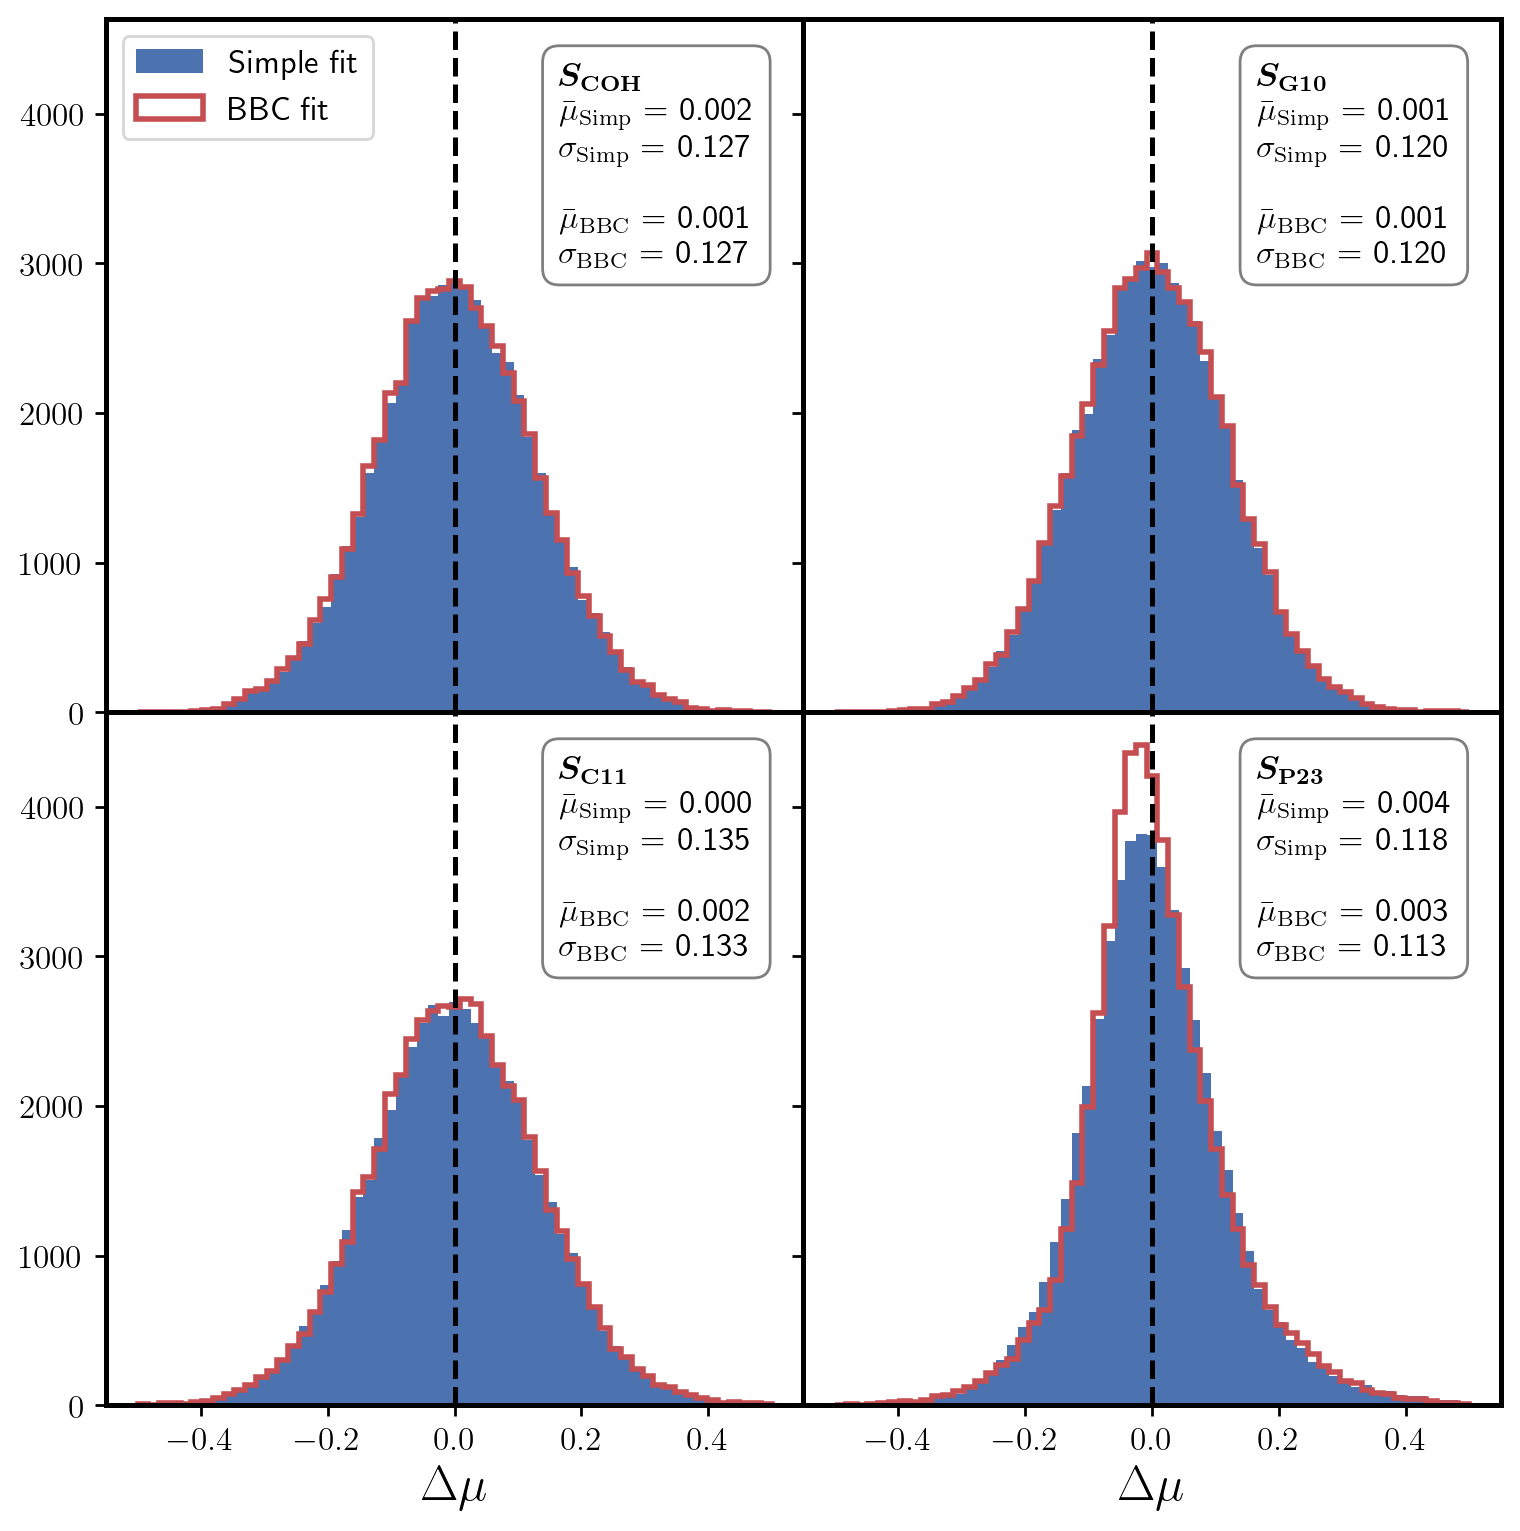

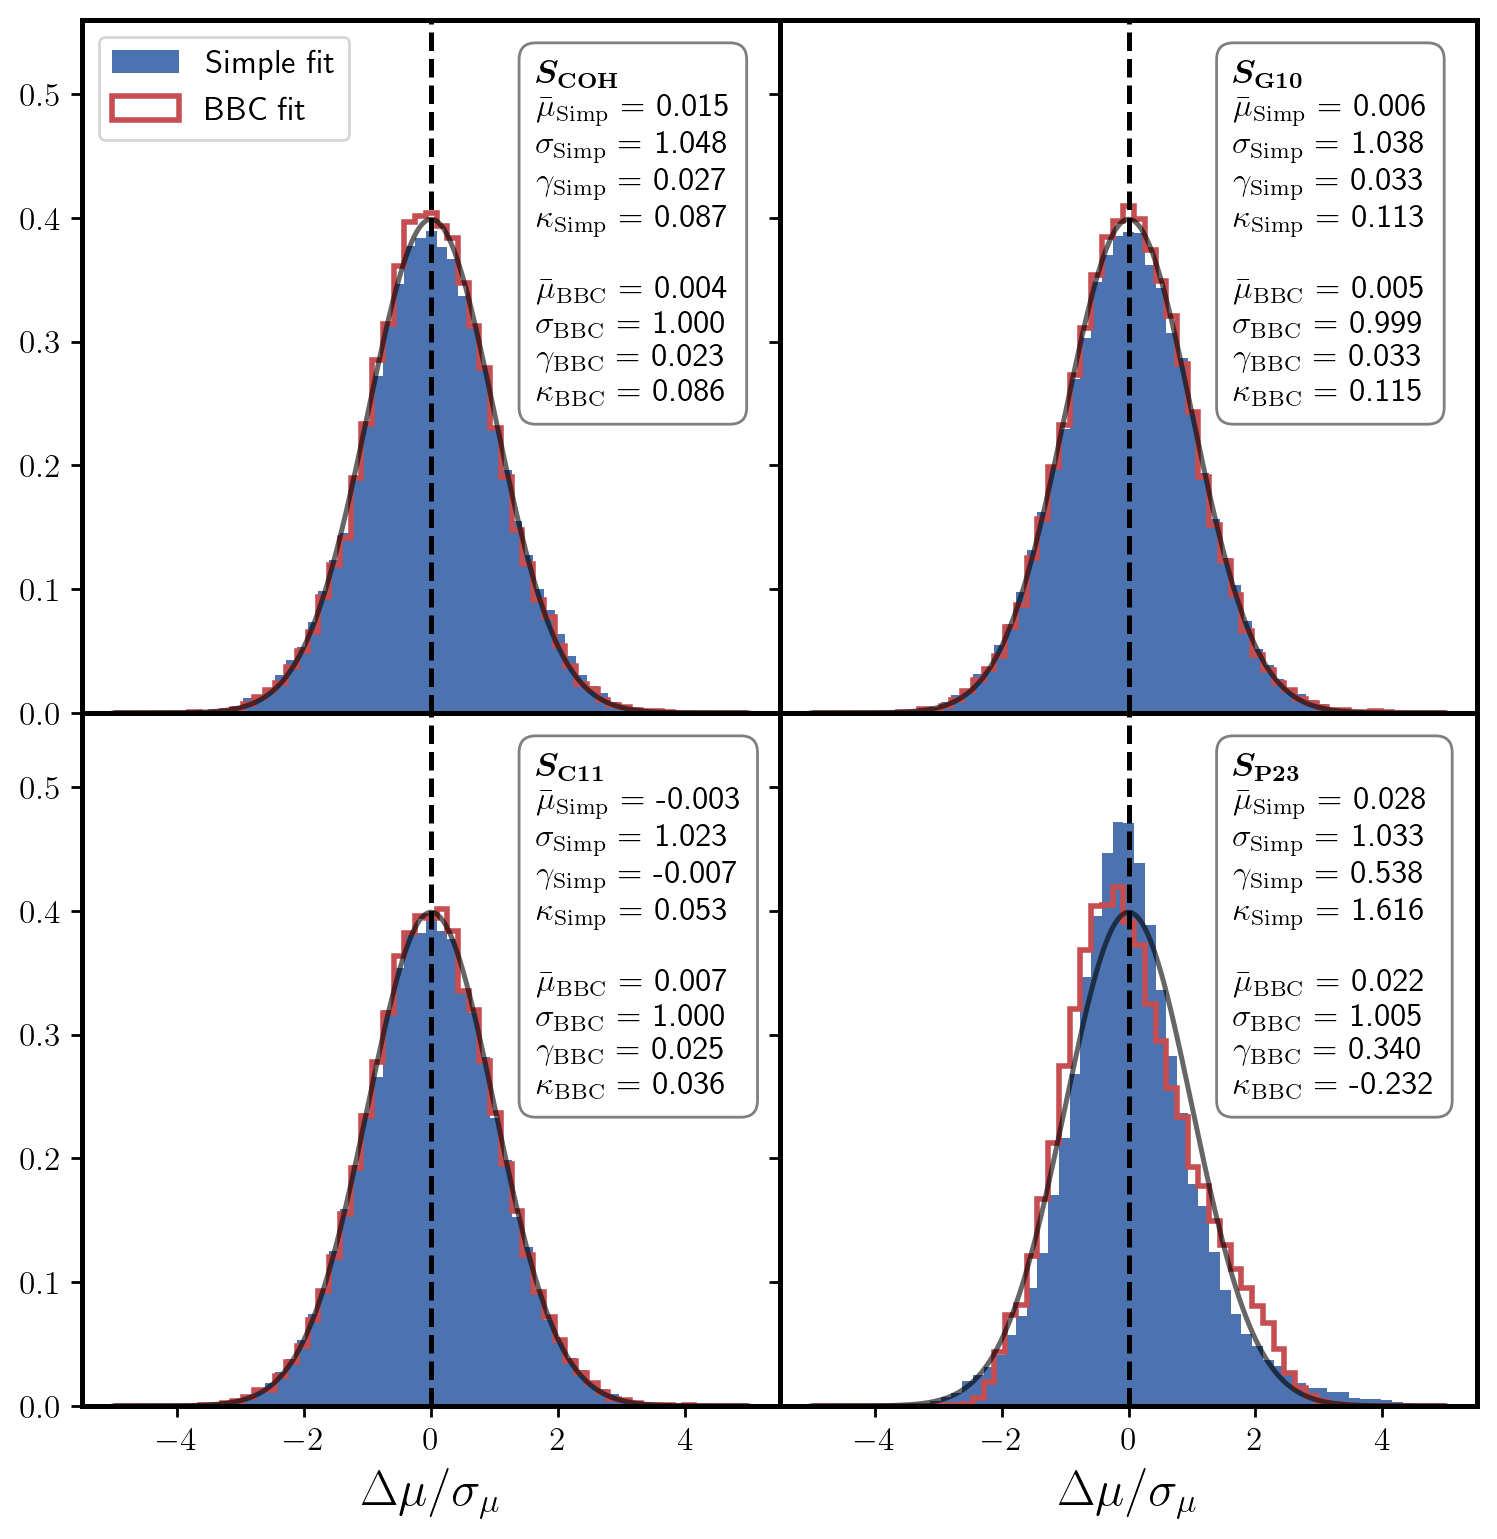

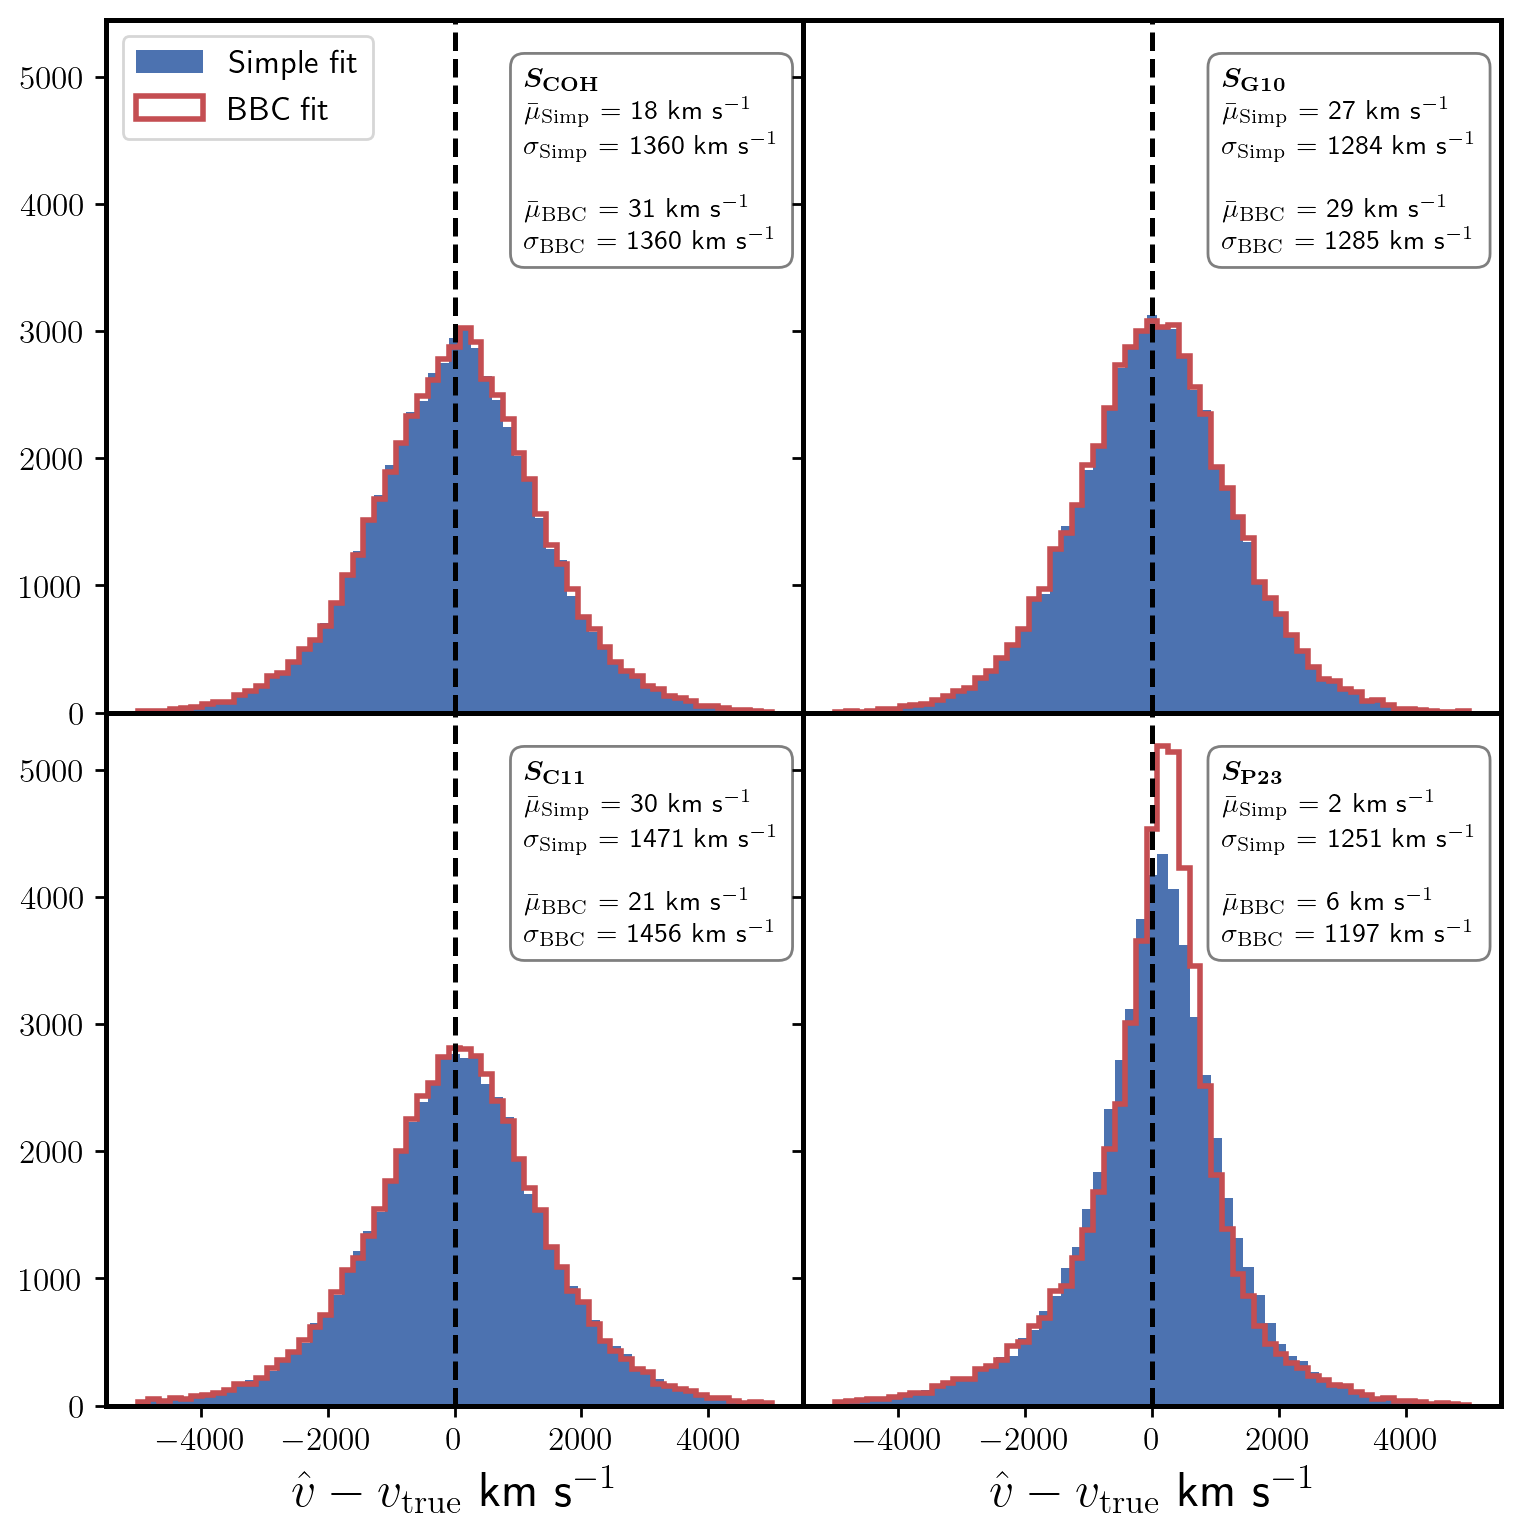

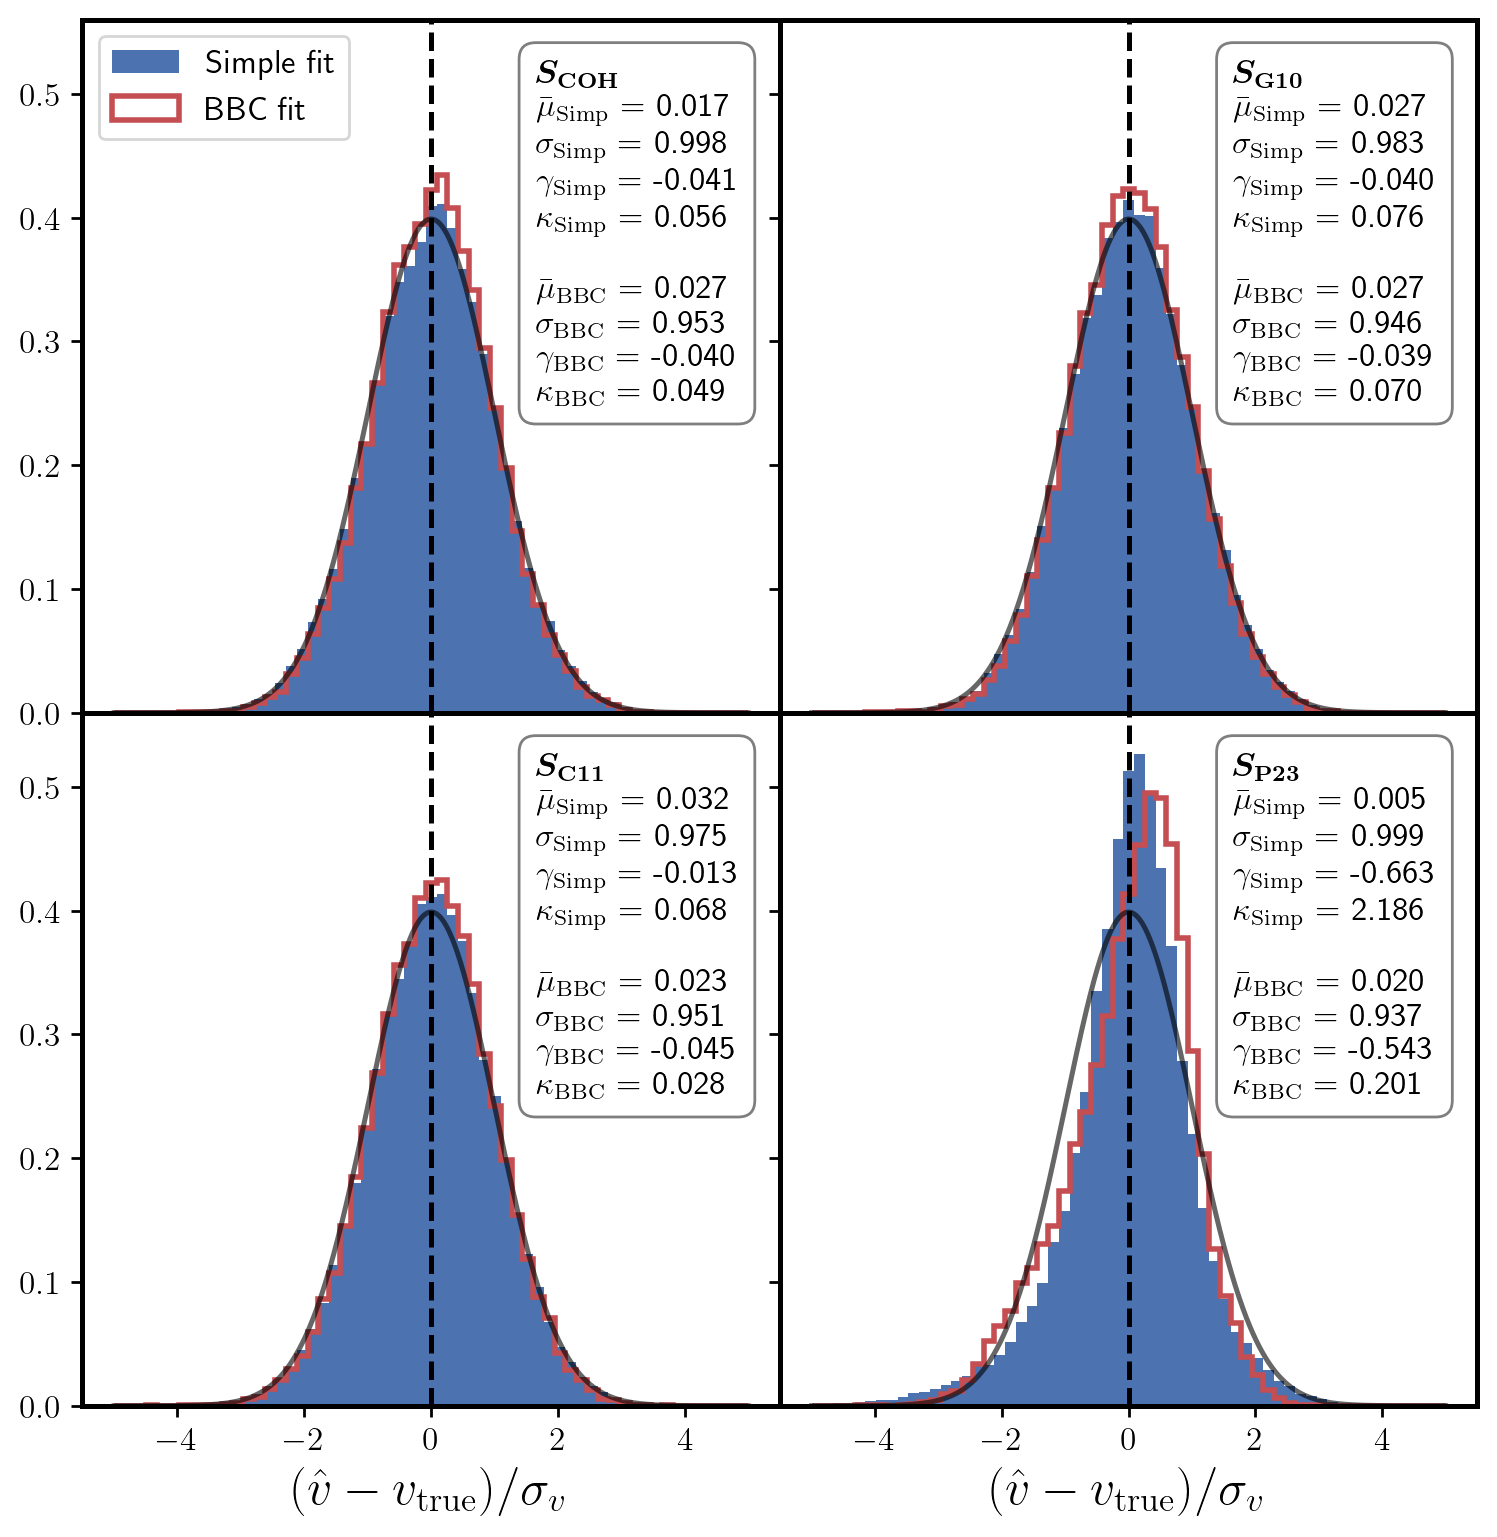

In [15]:
## HD RES ##
print('#-#-#-# HD RES #-#-#-#')
xrange = (-0.5, 0.5)
nbins=60
bins = np.linspace(xrange[0], xrange[1], nbins)
plot_hists(
    all_dmu_BBC, all_dmu_STDFIT, bins=bins, xrange=xrange, 
    filename='../Figures/HDres.pdf', xlabel=r'$\Delta\mu$', tpos=(0.65, 0.65)
)
    
## HD RES PULL ##
print('#-#-#-# HD PULL #-#-#-#')
xrange = (-5, 5)
nbins=60

bins = np.linspace(xrange[0], xrange[1], nbins)

all_HDpull_BBC = {}
all_HDpull_STDFIT = {}

for k in ['RNDSMEAR', 'G10', 'C11', 'P21']:
    all_HDpull_BBC[k] = all_dmu_BBC[k] / all_dmuerr_BBC[k]
    all_HDpull_STDFIT[k] = all_dmu_STDFIT[k] / all_dmuerr_STDFIT[k]
    
plot_hists(all_HDpull_BBC, all_HDpull_STDFIT, bins=bins, xrange=xrange, 
           filename='../Figures/HDpull.pdf', xlabel=r'$\Delta\mu / \sigma_\mu$', 
           density=True, plot_gauss=True, nonGauss=True, tpos=(0.65, 0.45), ylim=[0, 0.56])
## PV ##
print('#-#-#-# PV #-#-#-#')

xrange = (-5000, 5000)
nbins=60
bins = np.linspace(xrange[0], xrange[1], nbins)

all_dv_BBC = {}
all_dv_STDFIT = {}

for k in ['RNDSMEAR', 'G10', 'C11', 'P21']:
    all_dv_BBC[k] = (all_v_BBC[k] - all_vtrue_BBC[k]) 
    all_dv_STDFIT[k] = (all_v_STDFIT[k] - all_vtrue_STDFIT[k])

plot_hists(all_dv_BBC, all_dv_STDFIT, bins=bins, xrange=xrange, 
           filename='../Figures/Vbias.pdf', xlabel=r'$\hat{v} - v_\mathrm{true}$ km s$^{-1}$',
           tformat='.0f', tunit='km s$^{-1}$', tpos=(0.6,  0.67), text_fs=10)


## PV Pull ##
print('#-#-#-# PV PULL #-#-#-#')
xrange = (-5, 5)
nbins=60
bins = np.linspace(xrange[0], xrange[1], nbins)

all_dvpull_BBC = {}
all_dvpull_STDFIT = {}

for k in ['RNDSMEAR', 'G10', 'C11', 'P21']:
    all_dvpull_BBC[k] = (all_v_BBC[k] - all_vtrue_BBC[k]) / all_verr_BBC[k]
    all_dvpull_STDFIT[k] = (all_v_STDFIT[k] - all_vtrue_STDFIT[k]) / all_verr_STDFIT[k]

plot_hists(all_dvpull_BBC, all_dvpull_STDFIT, bins=bins, xrange=xrange, 
           filename='../Figures/Vbiaspull.pdf', xlabel=r'$(\hat{v} - v_\mathrm{true}) / \sigma_v$',
           density=True, plot_gauss=True, nonGauss=True, tpos=(0.65,  0.45), ylim=[0, 0.56])



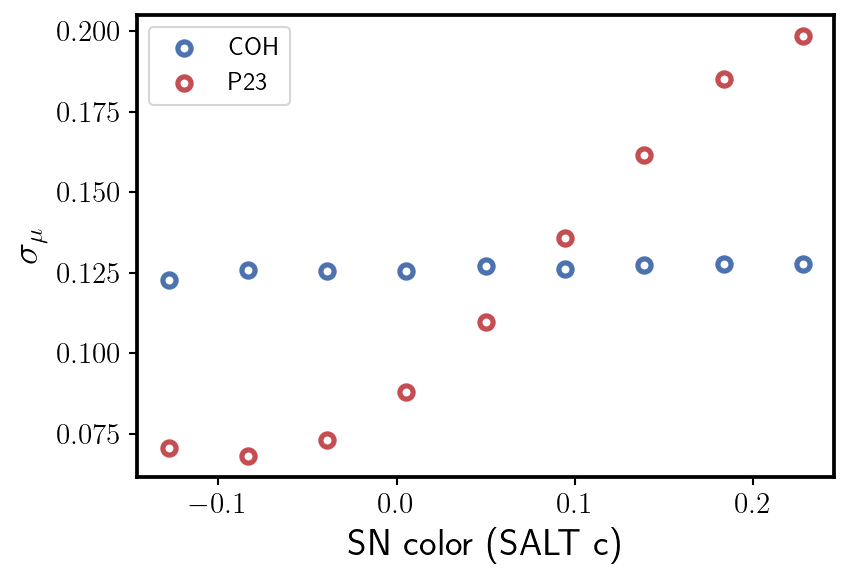

In [16]:
cbins = np.linspace(-0.15, 0.25,10)

from scipy.stats import binned_statistic
plt.figure(dpi=150)
for k, c in zip(['RNDSMEAR', 'P21'], ['C0', 'C2']):
    if k == 'RNDSMEAR':
        label = 'COH'
    elif k == 'P21':
        label='P23'
    else:
        label=k
        
    std = np.zeros(len(cbins) - 1)
    std_err = np.zeros(len(cbins) - 1)
    for i, (ca, cb) in enumerate(zip(cbins[:-1], cbins[1:])):
        mask = (all_c_STDFIT[k] >= ca) & (all_c_STDFIT[k] < cb)
        std[i] = np.std(all_dmu_STDFIT[k][mask])
        std_err[i] = std[i] / np.sqrt(2 * (np.sum(mask) -1))
    std, _, _ =  binned_statistic(all_c_STDFIT[k], all_dmu_STDFIT[k], bins=cbins, statistic='std')
    plt.scatter(0.5 * (cbins[:-1] + cbins[1:]), std, label=label, s=40, ec=c, fc='white', lw=2.5)
plt.legend()
plt.xlabel('SN color (SALT c)')
plt.ylabel(r'$\sigma_\mu$')
plt.savefig('scatter_mod.svg', dpi=300)

# Appendices

In [17]:
import yaml

# Simple fit par
SIMPLE_FIT_PAR = ['alpha', 'beta', 'gamma', 'sigma_M', 'M_0']

results_models_path = Path('../results/')

res_models = []
for f in sorted(results_models_path.glob('*_nojax.csv')):
    res_models.append(pd.read_csv(f, index_col=0))
resdf = pd.concat(res_models, keys=np.arange(8))

grp_models = resdf.groupby('model')

res_simple_fit = {}
res_bbc_fit = {}
for k in SIMPLE_FIT_PAR:
    res_simple_fit[k] = {
        'mean': grp_models[k + '_STDFIT'].mean(),
        'emean': grp_models[k + '_STDFIT'].std() / np.sqrt(8),
        'mean_err': np.sqrt(grp_models[k + '_ERR_STDFIT'].apply(lambda x: (x**2).mean())),
        'std': grp_models[k + '_STDFIT'].std()
    }


# BBC par
res_bbc_fit['M_0'] = {
        'mean': grp_models['M_0_BBC'].mean(),
        'emean': grp_models['M_0_BBC'].std() / np.sqrt(8),
        'mean_err': np.sqrt(grp_models['M_0_ERR_BBC'].apply(lambda x: (x**2).mean())),
        'std': grp_models['M_0_BBC'].std()
    }


data = {
    'model': [],
    'mock': []
}
for k in ['alpha', 'beta', 'gamma', 'sigma_M']:
    data[k] = []
    data[k + '_ERR'] = []

for mock in np.arange(8):
    MOCK_DIR = PIPPIN_DIR / f'LSST_UCHUU_MOCK{mock:02d}_BC'
    BBC_DIR = MOCK_DIR / '6_BIASCOR'
    
    for model in ['RNDSMEAR', 'G10', 'C11', 'P21']:
        BBC_FILE = BBC_DIR / f'LSST_{model}/output/BBC_SUMMARY_FITPAR.YAML'
       
        # Open files
        with open(BBC_FILE) as f:
            res_yml = yaml.safe_load(f)['OUTPUT_BBCFIT'][0]['FITOPT000_MUOPT000']

        for bbck, k in zip(
            ['alpha0', 'beta0', 'gamma0', 'SIGINT'],
            ['alpha', 'beta', 'gamma', 'sigma_M']
        ):
            val, err = res_yml[bbck].split('+_')
            
            data[k].append(float(val))
            data[k + '_ERR'].append(float(err))

        data['mock'].append(mock)
        data['model'].append(model)
grp_models = pd.DataFrame(data).groupby('model')

for k in ['alpha', 'beta', 'gamma', 'sigma_M']:
    res_bbc_fit[k] = {
        'mean': grp_models[k].mean(),
        'emean': grp_models[k].std() / np.sqrt(8),
        'mean_err': np.sqrt(grp_models[k + '_ERR'].apply(lambda x: (x**2).mean())),
        'std': grp_models[k].std()
    }


In [18]:
var = 'gamma'
labels = ["\simu{COH} & ", "\simu{G10} & ", "\simu{C11} & ", "\simu{P23} & "]
text = ''
for m,l in zip(['RNDSMEAR', 'G10', 'C11', 'P21'], labels):
    text  +=  l + f"{res_simple_fit[var]['mean'][m]:.5f} $\pm$ {res_simple_fit[var]['emean'][m]:.5f} & {res_simple_fit[var]['mean_err'][m]:.5f} & {res_bbc_fit[var]['mean'][m]:.5f} $\pm$ {res_bbc_fit[var]['emean'][m]:.5f} & {res_bbc_fit[var]['mean_err'][m]:.5f}\\"
    text += "\\" + " \n"
print(text)

\simu{COH} & 0.04854 $\pm$ 0.00109 & 0.00330 & 0.04632 $\pm$ 0.00078 & 0.00316\\ 
\simu{G10} & 0.04790 $\pm$ 0.00098 & 0.00312 & 0.04483 $\pm$ 0.00096 & 0.00297\\ 
\simu{C11} & 0.05400 $\pm$ 0.00116 & 0.00345 & 0.04766 $\pm$ 0.00119 & 0.00330\\ 
\simu{P23} & 0.07866 $\pm$ 0.00149 & 0.00295 & -0.00425 $\pm$ 0.00079 & 0.00196\\ 



In [19]:
var = 'alpha'
labels = ["\simu{COH} & ", "\simu{G10} & ", "\simu{C11} & ", "\simu{P23} & "]
text = ''
for m,l in zip(['RNDSMEAR', 'G10', 'C11', 'P21'], labels):
    text  +=  l + f"{res_simple_fit[var]['mean'][m]:.5f} $\pm$ {res_simple_fit[var]['emean'][m]:.5f} & {res_simple_fit[var]['mean_err'][m]:.5f} & {res_bbc_fit[var]['mean'][m]:.5f} $\pm$ {res_bbc_fit[var]['emean'][m]:.5f} & {res_bbc_fit[var]['mean_err'][m]:.5f}\\"
    text += "\\" + " \n"
print(text)

\simu{COH} & 0.14903 $\pm$ 0.00047 & 0.00134 & 0.14952 $\pm$ 0.00051 & 0.00128\\ 
\simu{G10} & 0.14871 $\pm$ 0.00043 & 0.00127 & 0.14903 $\pm$ 0.00041 & 0.00122\\ 
\simu{C11} & 0.14912 $\pm$ 0.00045 & 0.00140 & 0.14973 $\pm$ 0.00034 & 0.00134\\ 
\simu{P23} & 0.14992 $\pm$ 0.00014 & 0.00117 & 0.13994 $\pm$ 0.00014 & 0.00078\\ 



In [20]:
var = 'beta'
labels = ["\simu{COH} & ", "\simu{G10} & ", "\simu{C11} & ", "\simu{P23} & "]
text = ''
for m,l in zip(['RNDSMEAR', 'G10', 'C11', 'P21'], labels):
    text  +=  l + f"{res_simple_fit[var]['mean'][m]:.5f} $\pm$ {res_simple_fit[var]['emean'][m]:.5f} & {res_simple_fit[var]['mean_err'][m]:.5f} & {res_bbc_fit[var]['mean'][m]:.5f} $\pm$ {res_bbc_fit[var]['emean'][m]:.5f} & {res_bbc_fit[var]['mean_err'][m]:.5f}\\"
    text += "\\" + " \n"
print(text)

\simu{COH} & 3.08408 $\pm$ 0.00457 & 0.01461 & 3.09748 $\pm$ 0.00459 & 0.01403\\ 
\simu{G10} & 3.06474 $\pm$ 0.00514 & 0.01374 & 3.09081 $\pm$ 0.00451 & 0.01332\\ 
\simu{C11} & 3.50379 $\pm$ 0.00463 & 0.01555 & 3.78985 $\pm$ 0.00551 & 0.01625\\ 
\simu{P23} & 2.87411 $\pm$ 0.00578 & 0.01385 & 2.82785 $\pm$ 0.00274 & 0.01073\\ 

